In [2]:
# 1. Setup and Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from scipy.stats import rankdata

results_dir = 'results'
video_name = 'cecum_t2_a'
MATCHER_NAME = ['xfeat', 'gim-lg', 'disk-lg']
ensemble = "ensemble_topfrac0.5_thresh3"
export_dir = "data_anaysis_outputs"
os.makedirs(export_dir, exist_ok=True)
BASE_DIR = "results"
INVALID_GT_VIDEOS = {"seq1", "seq2", "seq3", "seq4"}



### Helper Functions

In [3]:
def load_ate_scalar(path):
    """ The ATE.npy file contains a single value per frame, which is the ATE for that frame.
    This function loads the ATE.npy file and returns the average ATE across all frames.
    """
    try:
        val = np.load(path)
        val = np.array(val).astype(float).flatten()
        return val.mean()  # Average ATE across frames
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None



def show_scrollable_df(df, max_height="400px", max_width="100%"):
    display(HTML(f"""
        <div style="max-height:{max_height}; max-width:{max_width}; overflow:auto; border:1px solid #ccc; padding:10px">
            {df.to_html(index=False)}
        </div>
    """))


def compute_motion(gt_poses):
    motions = []
    for i in range(1, len(gt_poses)):
        T1 = gt_poses[i-1]
        T2 = gt_poses[i]
        T_rel = np.linalg.inv(T1) @ T2
        trans = np.linalg.norm(T_rel[:3, 3])
        rot_deg = R.from_matrix(T_rel[:3, :3]).magnitude() * (180 / np.pi)
        motions.append({
            "frame": i,
            "combined_motion": trans + rot_deg
        })
    return pd.DataFrame(motions)




def compute_combined_rpe_normalised(df, rot_col="rotation_error_deg", trans_col="translation_error_deg"):
    df = df.copy()

    def minmax(series):
        return (series - series.min()) / (series.max() - series.min() + 1e-8)

    df["rot_norm"] = minmax(df[rot_col])
    df["trans_norm"] = minmax(df[trans_col])
    df["combined_rpe_normalised"] = (df["rot_norm"] + df["trans_norm"]) / 2

    return df






### Load and aggregate Data

In [4]:
import torch
import numpy as np
import pandas as pd
import os

video_level_stats = []
all_metrics = []
ate_dict = {}
skip_stats = []
screening_metrics = []  
screening_skip_stats = [] 

# Define matcher sources
matcher_sources = [
    {"base_dir": BASE_DIR, "matcher_list": MATCHER_NAME, "is_ensemble": False},
    {"base_dir": "results/Ensemble_ablation", "matcher_list": [ensemble], "is_ensemble": True}
]

for source in matcher_sources:
    base_dir = source["base_dir"]
    matcher_list = source["matcher_list"]
    is_ensemble = source["is_ensemble"]

    for video in os.listdir(base_dir):
        if video in INVALID_GT_VIDEOS:
            video_path = os.path.join(base_dir, video)
            if not os.path.isdir(video_path):
                continue

            for matcher in matcher_list:
                print(f"[INFO] Processing video: {video}, matcher: {matcher}, ensemble: {is_ensemble}")
                matcher_path = os.path.join(video_path, matcher)

                metrics_file = os.path.join(
                    matcher_path,
                    f"metrics_ensemble.csv" if is_ensemble else f"metrics_{matcher}.csv"
                )
                skip_log_file = os.path.join(
                    matcher_path,
                    f"skip_log_ensemble.csv" if is_ensemble else f"skip_log_{matcher}.csv"
                )

                # Load metrics
                if os.path.isfile(metrics_file):
                    df = pd.read_csv(metrics_file)
                    df["matcher"] = matcher
                    df["video"] = video
                    df = compute_combined_rpe_normalised(df)
                    screening_metrics.append(df)

                # Load skip log
                if os.path.isfile(skip_log_file):
                    try:
                        skip_df = pd.read_csv(skip_log_file)
                        total = len(skip_df)
                        failed = skip_df["success"].value_counts().get(False, 0)
                        avg_skip_used = skip_df["skip_used"].mean()

                        screening_skip_stats.append({
                            "matcher": matcher,
                            "video": video,
                            "failures": failed,
                            "total": total,
                            "failure_rate": failed / total if total > 0 else np.nan,
                            "avg_skip_used": avg_skip_used
                        })
                    except Exception as e:
                        print(f"[WARN] Failed to load skip log from {skip_log_file}: {e}")
            continue  # skip further processing for invalid videos
        

        video_path = os.path.join(base_dir, video)
        if not os.path.isdir(video_path):
            continue

        for matcher in matcher_list:
            matcher_path = os.path.join(video_path, matcher)

            # Adjust filenames for ensemble
            metrics_file = os.path.join(
                matcher_path,
                f"metrics_ensemble.csv" if is_ensemble else f"metrics_{matcher}.csv"
            )
            ate_file = os.path.join(
                matcher_path,
                f"ate_ensemble.npy" if is_ensemble else f"ate_{matcher}.npy"
            )
            skip_log_file = os.path.join(
                matcher_path,
                f"skip_log_ensemble.csv" if is_ensemble else f"skip_log_{matcher}.csv"
            )
            matches_dir = os.path.join(matcher_path, "matches")

            # Load metrics
            if os.path.isfile(metrics_file):
                df = pd.read_csv(metrics_file)
                df["matcher"] = matcher
                df["video"] = video
                df = compute_combined_rpe_normalised(df)
                num_frames = len(df)

                if num_frames > 5:
                    mean_combined_rpe = df["combined_rpe_normalised"].mean()
                else:
                    mean_combined_rpe = np.nan

                all_metrics.append(df)

            # Load ATE
            ate_value = None
            if os.path.isfile(ate_file):
                ate_value = load_ate_scalar(ate_file)
                if ate_value is not None and ate_value > 0:
                    ate_dict.setdefault(matcher, []).append(ate_value)
                else:
                    print(f"[SKIP] Invalid or 0 ATE for {matcher} ({video})")

            # Load average match count from .torch files
            avg_matches_per_frame = np.nan
            if os.path.isdir(matches_dir):
                match_counts = []
                try:
                    for fname in os.listdir(matches_dir):
                        # print(f"[INFO] Checking file: {fname}")
                        if fname.endswith(".torch"):
                            data = torch.load(os.path.join(matches_dir, fname), map_location='cpu', weights_only=False)
                            # print(f"[INFO] Loaded {fname} with keys: {list(data.keys())}")
                            if "mkpts0" in data:
                                match_counts.append(len(data["mkpts0"]))
                            elif "mkpts1" in data:
                                match_counts.append(len(data["mkpts1"]))
                            else:
                                print(f"[WARN] No match points found in {fname}")
                    if match_counts:
                        avg_matches_per_frame = np.mean(match_counts)
                except Exception as e:
                    print(f"[WARN] Failed to read .torch matches from {matches_dir}: {e}")

            # Store video-level stats
            if ate_value is not None:
                num_frames = len(df) if 'df' in locals() else np.nan
                video_level_stats.append({
                    "matcher": matcher,
                    "video": video,
                    "combined_rpe_normalised_mean": mean_combined_rpe,
                    "ATE": ate_value,
                    "num_frames": num_frames,
                    "avg_matches_per_frame": avg_matches_per_frame
                })

            # Load skip log
            if os.path.isfile(skip_log_file):
                try:
                    skip_df = pd.read_csv(skip_log_file)
                    total = len(skip_df)
                    failed = skip_df["success"].value_counts().get(False, 0)
                    avg_skip_used = skip_df["skip_used"].mean()

                    skip_stats.append({
                        "matcher": matcher,
                        "video": video,
                        "failures": failed,
                        "total": total,
                        "failure_rate": failed / total if total > 0 else np.nan,
                        "avg_skip_used": avg_skip_used
                    })
                except Exception as e:
                    print(f"[WARN] Failed to load skip log from {skip_log_file}: {e}")

# Combine and aggregate
metrics_df = pd.concat(all_metrics, ignore_index=True)

agg_funcs = {
    "rotation_error_deg": ["mean", "std"],
    "translation_error_deg": ["mean", "std"],
    "mean_reprojection_error_px": ["mean", "std"],
    "combined_rpe_normalised": ["mean", "std"]
}
summary_df = metrics_df.groupby("matcher").agg(agg_funcs)
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

# Add ATE stats
summary_df["ATE_mean"] = summary_df["matcher"].map(lambda m: np.mean(ate_dict.get(m, [np.nan])))
summary_df["ATE_std"] = summary_df["matcher"].map(lambda m: np.std(ate_dict.get(m, [np.nan])))

# Skip log stats
skip_df = pd.DataFrame(skip_stats)
skip_summary = skip_df.groupby("matcher").agg({
    "failure_rate": "mean",
    "avg_skip_used": "mean"
}).reset_index()
summary_df = summary_df.merge(skip_summary, on="matcher", how="left")

# Per-video stats
video_stats_df = pd.DataFrame(video_level_stats)
video_stats_df = video_stats_df.sort_values("video")

# Output
show_scrollable_df(summary_df)
show_scrollable_df(video_stats_df)


screening_metrics_df = pd.concat(screening_metrics, ignore_index=True)
screening_skip_df = pd.DataFrame(screening_skip_stats)

show_scrollable_df(screening_metrics_df)
show_scrollable_df(screening_skip_df)



[INFO] Processing video: seq3, matcher: xfeat, ensemble: False
[INFO] Processing video: seq3, matcher: gim-lg, ensemble: False
[INFO] Processing video: seq3, matcher: disk-lg, ensemble: False
[INFO] Processing video: seq4, matcher: xfeat, ensemble: False
[INFO] Processing video: seq4, matcher: gim-lg, ensemble: False
[INFO] Processing video: seq4, matcher: disk-lg, ensemble: False
[INFO] Processing video: seq2, matcher: xfeat, ensemble: False
[INFO] Processing video: seq2, matcher: gim-lg, ensemble: False
[INFO] Processing video: seq2, matcher: disk-lg, ensemble: False
[SKIP] Invalid or 0 ATE for disk-lg (trans_t1_a)
[INFO] Processing video: seq1, matcher: xfeat, ensemble: False
[INFO] Processing video: seq1, matcher: gim-lg, ensemble: False
[INFO] Processing video: seq1, matcher: disk-lg, ensemble: False
[SKIP] Invalid or 0 ATE for disk-lg (trans_t2_b)
[INFO] Processing video: seq3, matcher: ensemble_topfrac0.5_thresh3, ensemble: True
[INFO] Processing video: seq4, matcher: ensemble_t

### Overall stats - bar plot

In [5]:
print(summary_df.columns)

Index(['matcher', 'rotation_error_deg_mean', 'rotation_error_deg_std',
       'translation_error_deg_mean', 'translation_error_deg_std',
       'mean_reprojection_error_px_mean', 'mean_reprojection_error_px_std',
       'combined_rpe_normalised_mean', 'combined_rpe_normalised_std',
       'ATE_mean', 'ATE_std', 'failure_rate', 'avg_skip_used'],
      dtype='object')


In [6]:

# Sort by ATE_mean so the best-performing matcher is on top
sorted_df = summary_df.sort_values("mean_reprojection_error_px_mean", ascending=True).reset_index(drop=True)

# Shared color palette for consistent coloring across plots
bar_colors = ['#66c2a5', '#8da0cb', '#e78ac3', '#ffd92f']  # From ColorBrewer, similar to screenshot

# Metrics: (Title, Mean column, Std column or None)
metrics = [
    ("Rotation Error Deg Mean (degrees)", "rotation_error_deg_mean", "rotation_error_deg_std"),
    ("Translation Error Deg Mean (degrees)", "translation_error_deg_mean", "translation_error_deg_std"),
    ("Mean Reprojection Error Px Mean (pixels)", "mean_reprojection_error_px_mean", "mean_reprojection_error_px_std"),
    ("Ate Mean (mm)", "ATE_mean", "ATE_std"),
    ("Failure Rate (pose failures/total poses)", "failure_rate", None),
    ("Avg Skip Used (frame length of skip window)", "avg_skip_used", None),
]

# Set up plot
fig, axs = plt.subplots(2, 3, figsize=(15, 9))
axs = axs.flatten()

matchers = sorted_df["matcher"].values
x = np.arange(len(matchers))

for i, (title, mean_col, std_col) in enumerate(metrics):
    ax = axs[i]
    means = sorted_df[mean_col].values
    errors = sorted_df[std_col].values if std_col else None

    # Manually trim lower error bars to not go below zero
    if errors is not None:
        lower_errors = np.minimum(errors, means)  # trim at zero
        yerr = [lower_errors, errors]
    else:
        yerr = None

    ax.bar(x, means, yerr=yerr, capsize=5, color=bar_colors, ecolor='black')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(matchers, rotation=45, ha='right')
    ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'full_metrics_summary.png'), dpi=300)
# plt.show()


### Average number of matches, per video, per matcher

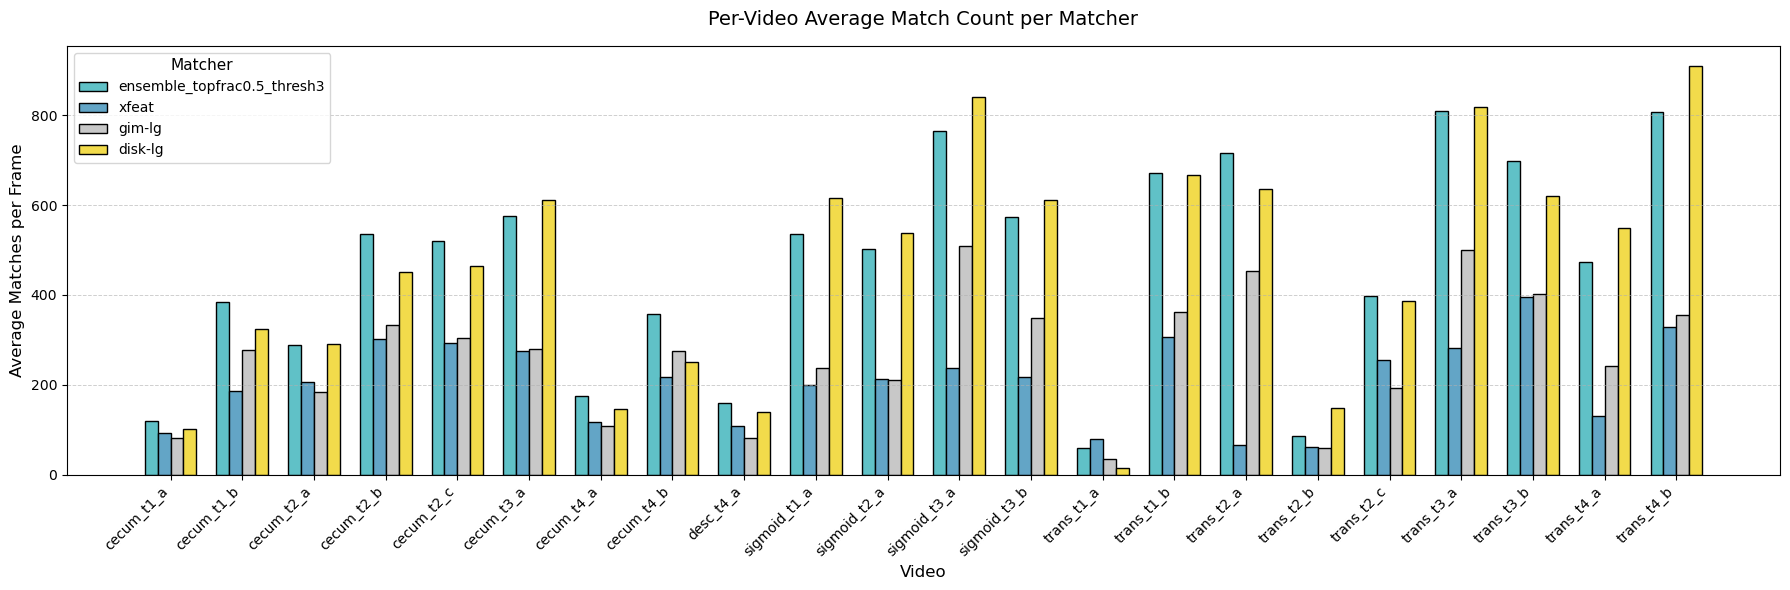

In [7]:
# Clean and sort the data
plot_df = video_stats_df.dropna(subset=["avg_matches_per_frame"])
plot_df = plot_df.sort_values("video")

videos = plot_df["video"].unique()
matchers = plot_df["matcher"].unique()

x = np.arange(len(videos))  # one position per group
bar_width = 0.18
fig, ax = plt.subplots(figsize=(18, 6))

# Define distinct, readable colors
colors = {
    "ensemble_topfrac0.5_thresh3": "#60c1c7",  # blue
    "xfeat": "#63a5c6",                        # orange
    "gim-lg": "#c8c8c8",                       # green
    "disk-lg": "#f2db4b"                       # red
}

# Plot each matcher
for i, matcher in enumerate(matchers):
    matcher_data = plot_df[plot_df["matcher"] == matcher]
    y_vals = [matcher_data[matcher_data["video"] == vid]["avg_matches_per_frame"].values[0]
              if not matcher_data[matcher_data["video"] == vid].empty else 0 for vid in videos]

    bar_positions = x + i * bar_width - (bar_width * (len(matchers) - 1) / 2)
    ax.bar(bar_positions, y_vals, width=bar_width,
           label=matcher, color=colors.get(matcher, None), edgecolor='black')

# Axis labels
ax.set_ylabel("Average Matches per Frame", fontsize=12)
ax.set_xlabel("Video", fontsize=12)
ax.set_title("Per-Video Average Match Count per Matcher", fontsize=14, pad=15)

# X-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(videos, rotation=45, ha='right', fontsize=10)

# Gridlines
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Legend (key)
ax.legend(title="Matcher", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(export_dir, "avg_matches_per_video_grouped_final.png"), dpi=300)
# plt.show()


### Correlation between Motion and Reproj error

In [8]:
from scipy.spatial.transform import Rotation as R
from scipy.stats import pearsonr, spearmanr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

matcher_sources = [
    {"base_dir": BASE_DIR, "matcher_list": MATCHER_NAME, "is_ensemble": False},
    {"base_dir": "results/Ensemble_ablation", "matcher_list": [ensemble], "is_ensemble": True}
]

for source in matcher_sources:
    base_dir = source["base_dir"]
    matcher_list = source["matcher_list"]
    is_ensemble = source["is_ensemble"]

    for video in os.listdir(base_dir):
        if video in INVALID_GT_VIDEOS:
            continue

        video_path = os.path.join(base_dir, video)
        gt_pose_folder = os.path.join(video_path, "gt_poses")

        if not os.path.isdir(gt_pose_folder):
            continue

        # --- Step 1: Load GT Motion ---
        motion_data = []
        for fname in sorted(os.listdir(gt_pose_folder)):
            if not fname.endswith(".npy"):
                continue
            parts = fname.replace(".npy", "").split("_")
            if len(parts) < 4:
                continue
            try:
                i1, i2 = int(parts[2]), int(parts[3])
            except:
                continue

            T = np.load(os.path.join(gt_pose_folder, fname))
            trans = np.linalg.norm(T[:3, 3])
            rot_deg = R.from_matrix(T[:3, :3]).magnitude() * (180 / np.pi)
            motion_data.append({
                "frame": i2,
                "translation": trans,
                "rotation_deg": rot_deg,
                "combined_motion": trans + rot_deg
            })

        motion_df = pd.DataFrame(motion_data)
        if motion_df.empty:
            continue

        # --- Step 2: Collect metrics from all matchers ---
        rpe_frames = []
        for matcher in matcher_list:
            matcher_path = os.path.join(video_path, matcher)
            metrics_file = os.path.join(
                matcher_path,
                f"metrics_ensemble.csv" if is_ensemble else f"metrics_{matcher}.csv"
            )
            if not os.path.isfile(metrics_file):
                continue

            df = pd.read_csv(metrics_file)
            df = df.reset_index().rename(columns={"index": "frame"})
            df["matcher"] = matcher
            if "frame" not in df.columns:
                continue

            rpe_frames.append(df)

        if not rpe_frames:
            continue

        rpe_all = pd.concat(rpe_frames)
        avg_rpe_df = rpe_all.groupby("frame").mean(numeric_only=True).reset_index()
        avg_rpe_df["frame"] = avg_rpe_df["frame"] * 30  # Adjust if needed

        # --- Step 3: Merge and Plot ---
        plot_df = motion_df.merge(avg_rpe_df, on="frame")
        if plot_df.empty:
            continue

        # --- Compute and print correlation ---
        x = plot_df["mean_reprojection_error_px"]
        y = plot_df["combined_motion"]
        if len(x) > 1 and len(y) > 1:
            pearson_corr, _ = pearsonr(x, y)
            spearman_corr, _ = spearmanr(x, y)
            print(f"[{video}] Pearson correlation: {pearson_corr:.3f}")
            print(f"[{video}] Spearman correlation: {spearman_corr:.3f}")
        else:
            print(f"[{video}] Not enough data points to compute correlation.")

        # --- Plot: motion vs reprojection error ---
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.7)
        plt.xlabel("Avg Reprojection Error (px)")
        plt.ylabel("GT Motion Magnitude (Translation + Rotation in deg)")
        plt.title(f"Motion vs. Reprojection Error — Video: {video}")
        plt.grid(True)
        plt.tight_layout()

        os.makedirs(export_dir, exist_ok=True)
        plt.savefig(os.path.join(export_dir, f"motion_vs_rpe_scatter_{video}.png"), dpi=300)
        plt.close()

[cecum_t2_c] Pearson correlation: 0.130
[cecum_t2_c] Spearman correlation: 0.232
[sigmoid_t3_a] Pearson correlation: -0.567
[sigmoid_t3_a] Spearman correlation: -0.549
[cecum_t2_a] Pearson correlation: 0.198
[cecum_t2_a] Spearman correlation: 0.264
[cecum_t1_a] Pearson correlation: 0.257
[cecum_t1_a] Spearman correlation: 0.485
[desc_t4_a] Pearson correlation: -0.898
[desc_t4_a] Spearman correlation: -0.500
[trans_t3_a] Pearson correlation: -0.232
[trans_t3_a] Spearman correlation: -0.300
[cecum_t2_b] Pearson correlation: -0.495
[cecum_t2_b] Spearman correlation: -0.533
[cecum_t4_b] Pearson correlation: 0.539
[cecum_t4_b] Spearman correlation: 0.505
[cecum_t1_b] Pearson correlation: 0.390
[cecum_t1_b] Spearman correlation: 0.369
[trans_t3_b] Pearson correlation: -0.397
[trans_t3_b] Spearman correlation: -0.613
[sigmoid_t3_b] Pearson correlation: 0.396
[sigmoid_t3_b] Spearman correlation: 0.447
[trans_t2_a] Pearson correlation: 0.018
[trans_t2_a] Spearman correlation: 0.609
[sigmoid_t1_

### Plotting Motion vs RPE 

In [9]:

# print(f"Loaded metrics: {len(all_metrics)} entries")
# print(pd.concat(all_metrics).head())


[cecum_t2_c | xfeat] Pearson: 0.176, Spearman: 0.267
[cecum_t2_c | gim-lg] Pearson: 0.278, Spearman: 0.207
[cecum_t2_c | disk-lg] Pearson: 0.305, Spearman: 0.286
[sigmoid_t3_a | xfeat] Pearson: 0.014, Spearman: -0.016
[sigmoid_t3_a | gim-lg] Pearson: 0.165, Spearman: 0.127
[sigmoid_t3_a | disk-lg] Pearson: -0.184, Spearman: -0.140
[cecum_t2_a | xfeat] Pearson: -0.084, Spearman: 0.035
[cecum_t2_a | gim-lg] Pearson: -0.128, Spearman: -0.147
[cecum_t2_a | disk-lg] Pearson: 0.153, Spearman: 0.140
[cecum_t1_a | xfeat] Pearson: -0.525, Spearman: -0.467
[cecum_t1_a | gim-lg] Pearson: -0.656, Spearman: -0.771
[cecum_t1_a | disk-lg] Pearson: -0.338, Spearman: -0.357
[desc_t4_a | xfeat] Pearson: -0.944, Spearman: -1.000
[desc_t4_a | gim-lg] Pearson: -0.254, Spearman: -0.800
[desc_t4_a | disk-lg] Pearson: 0.764, Spearman: 0.400
[trans_t3_a | xfeat] Pearson: 0.759, Spearman: 0.257
[trans_t3_a | gim-lg] Pearson: 0.298, Spearman: 0.393
[trans_t3_a | disk-lg] Pearson: 0.304, Spearman: 0.107
[cecum_t2

/tmp/ipykernel_2649688/2838615642.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


[trans_t1_b] Avg Pearson: -0.362, Avg Spearman: -0.204

[INFO] Plotting video: trans_t2_c with 4 matcher(s)
[trans_t2_c] Avg Pearson: 0.322, Avg Spearman: 0.277


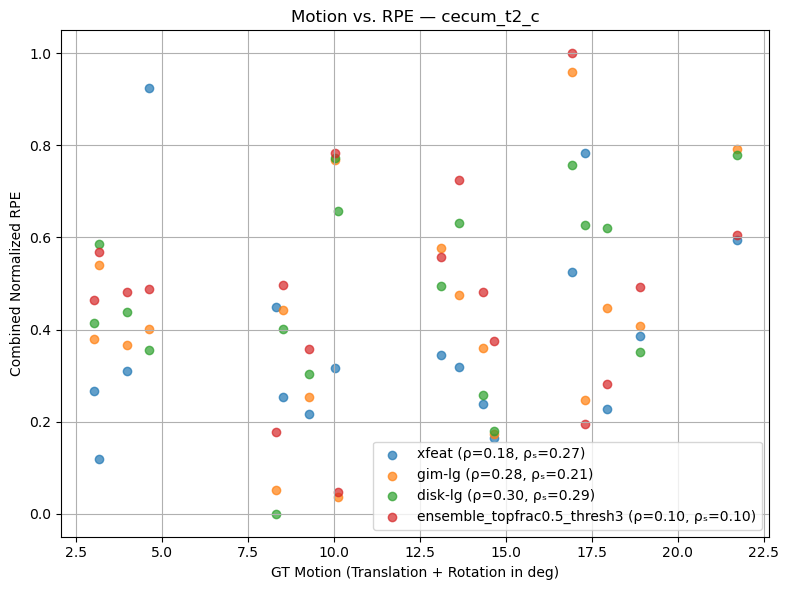

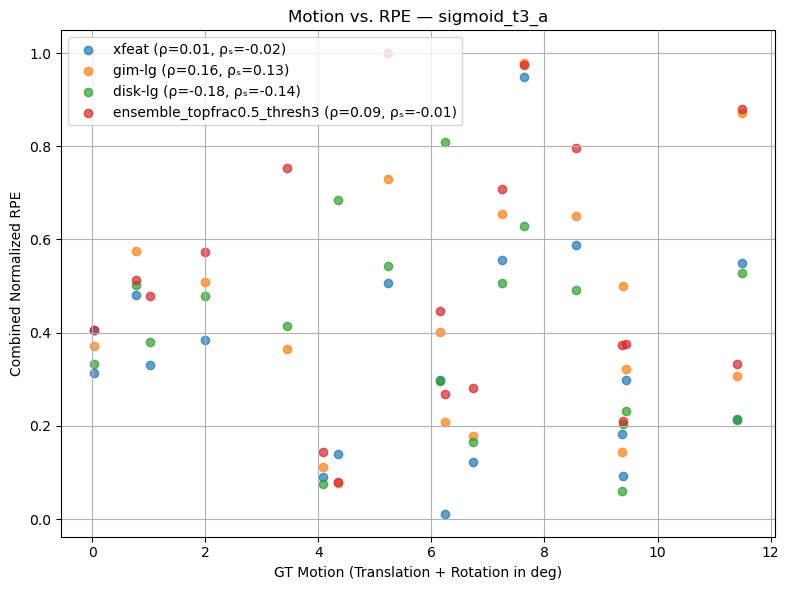

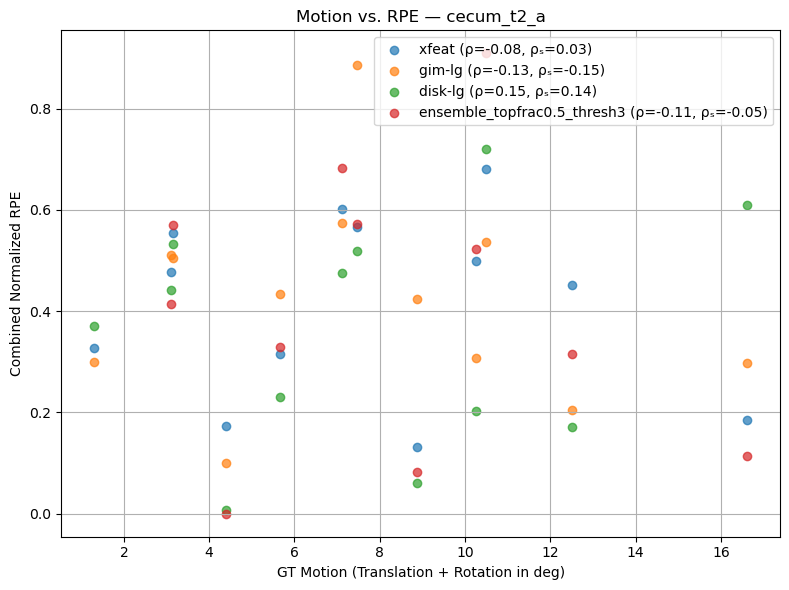

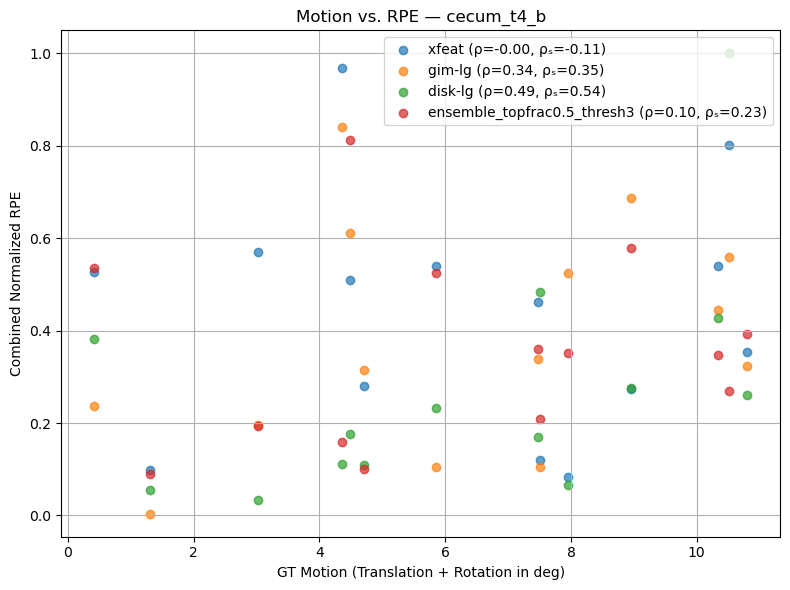

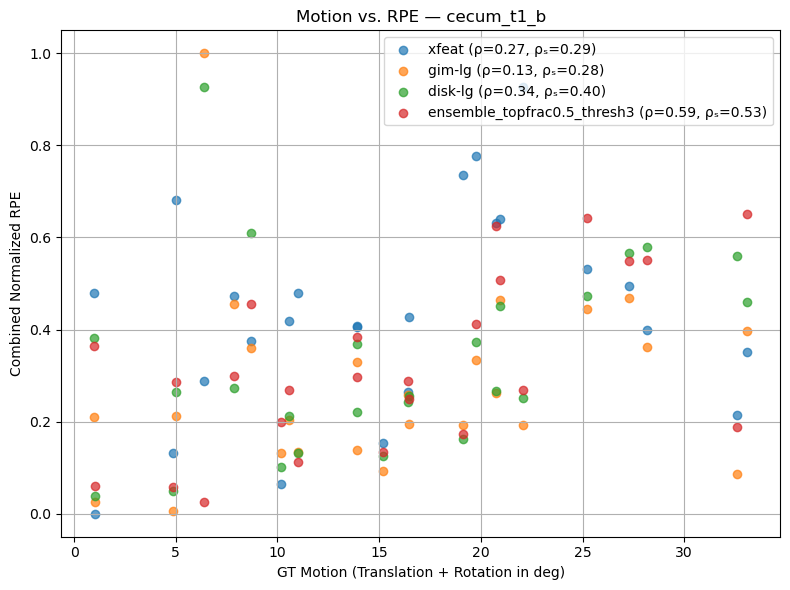

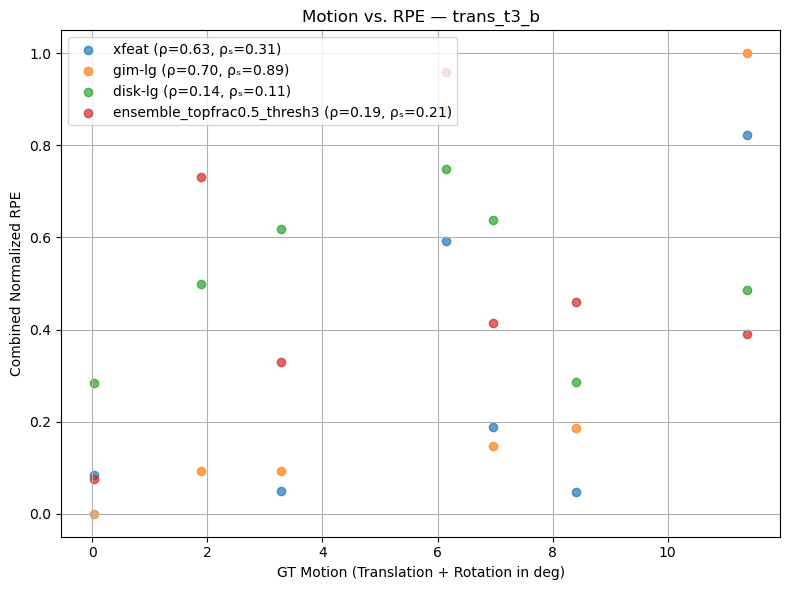

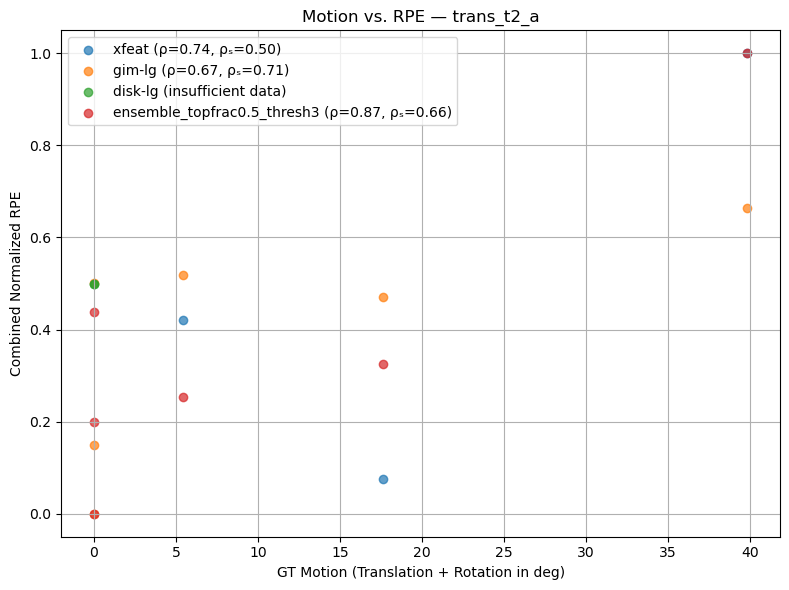

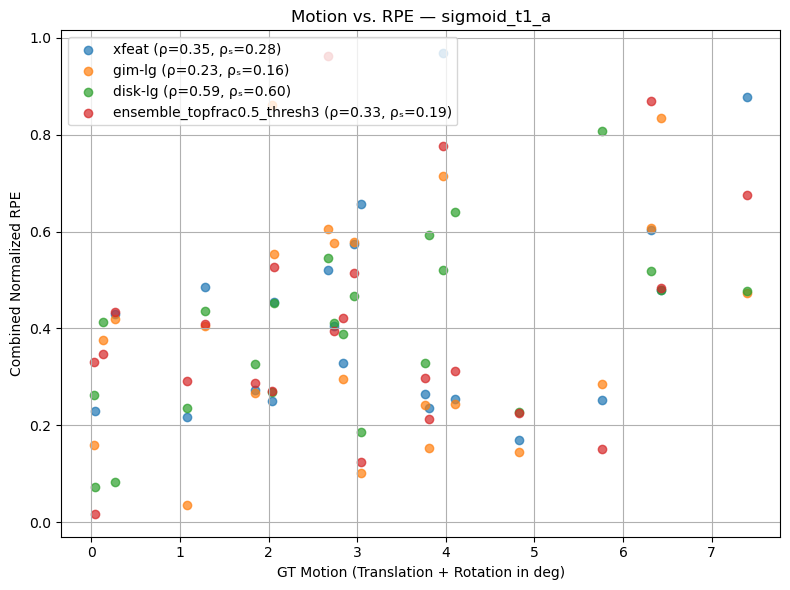

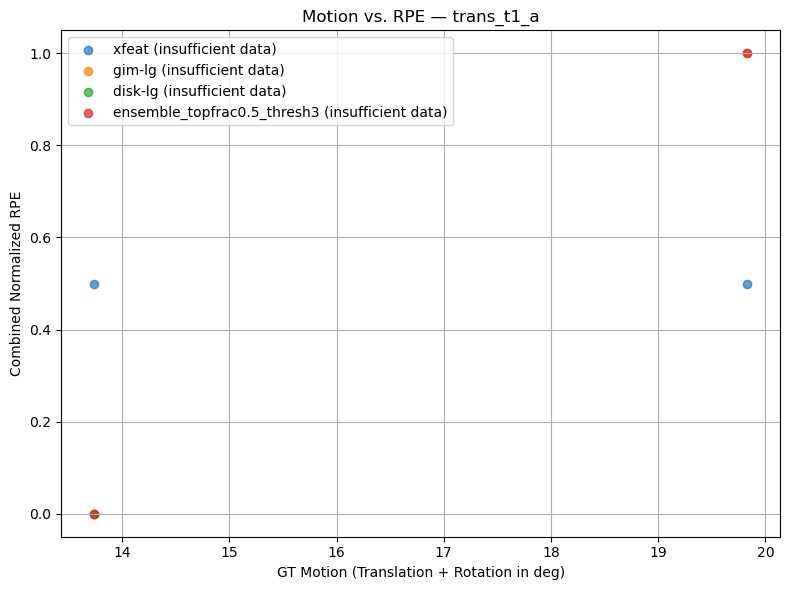

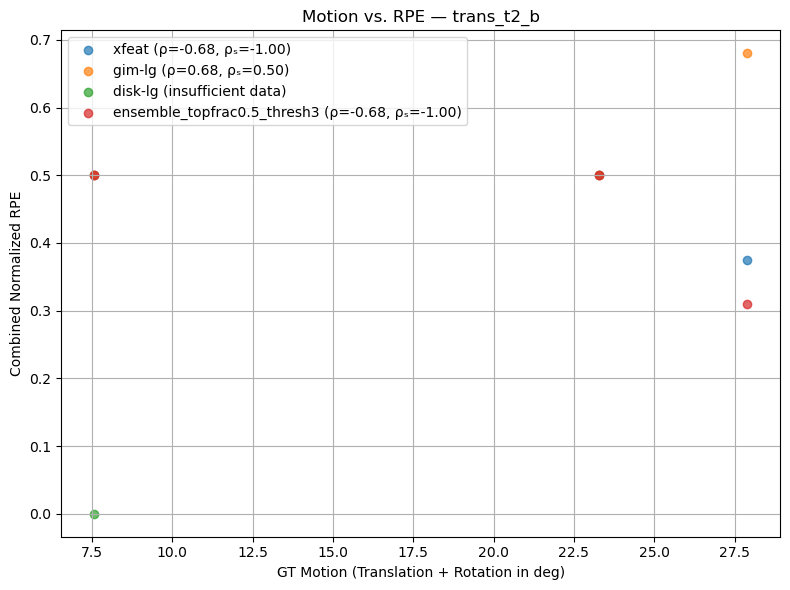

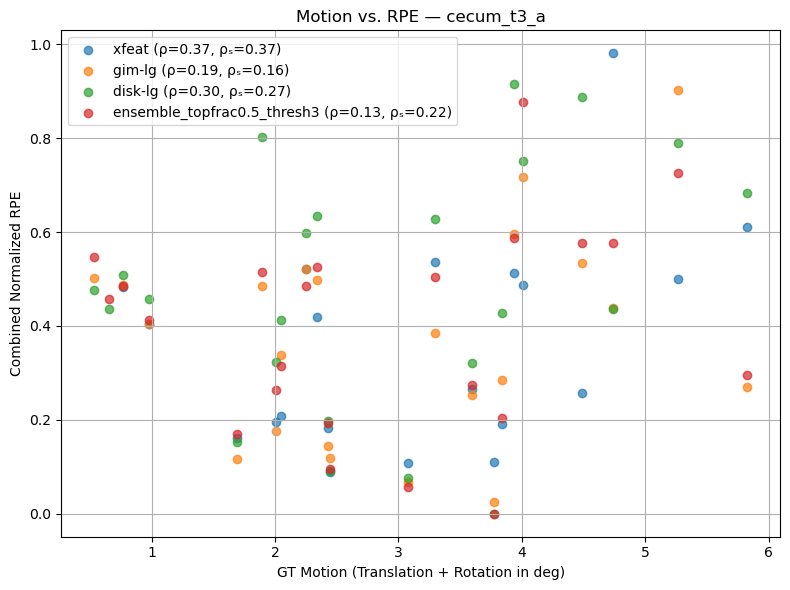

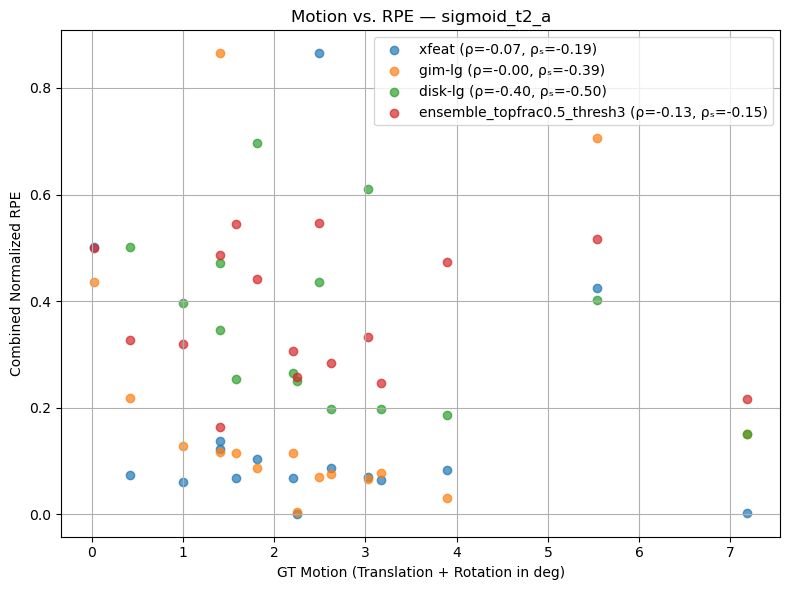

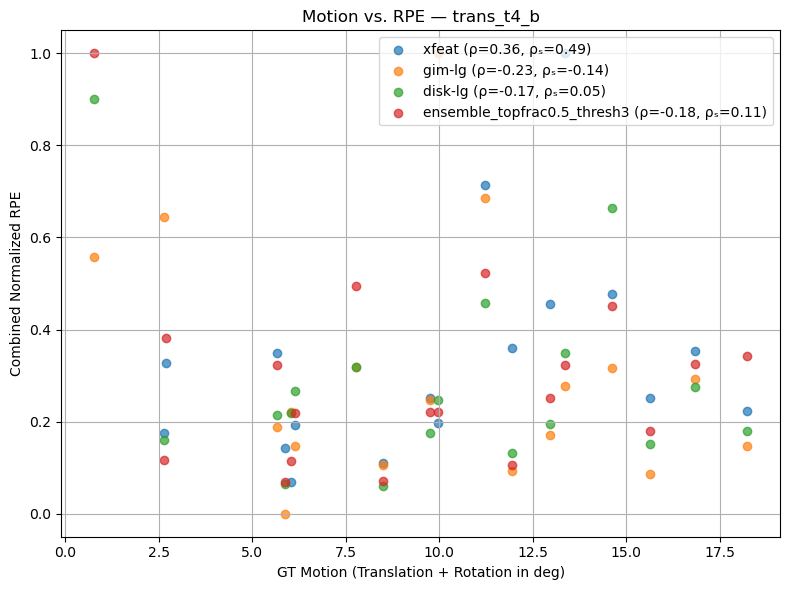

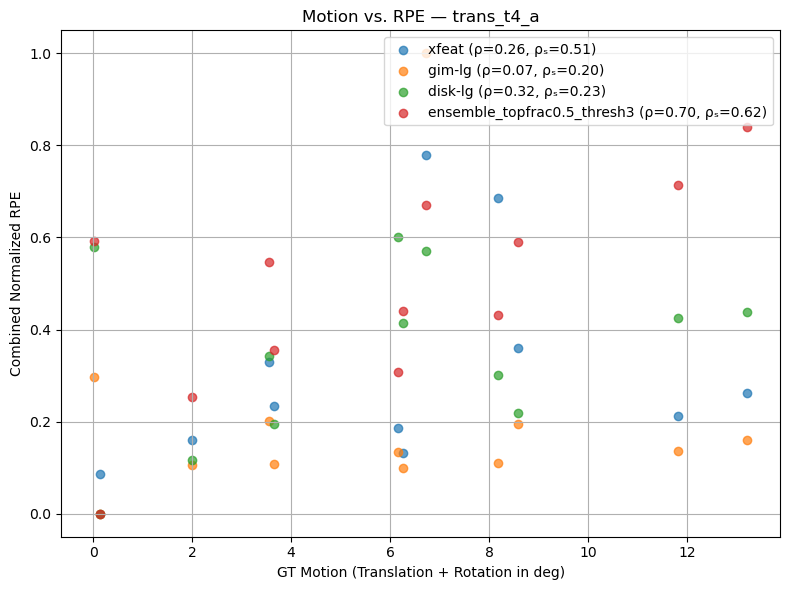

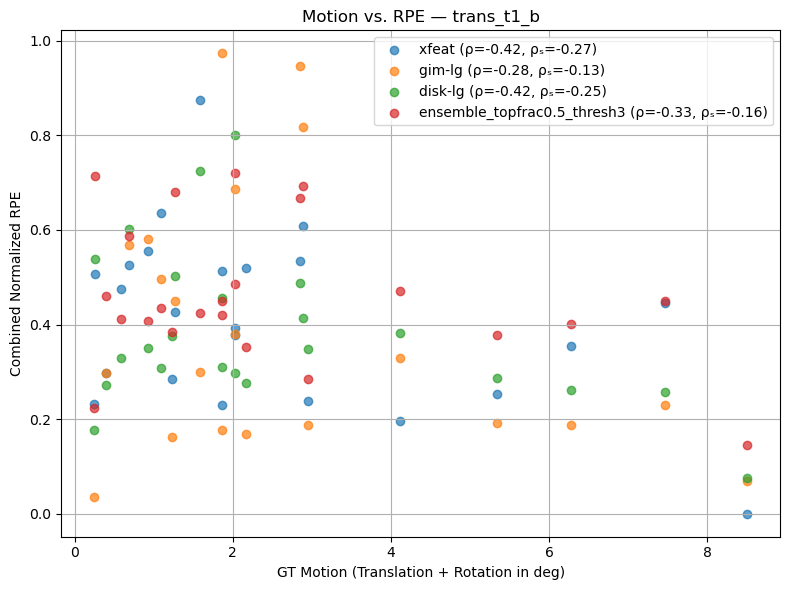

In [10]:
from scipy.spatial.transform import Rotation as R
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# Merge all per-video DataFrames
all_metrics_merged = pd.concat(all_metrics, ignore_index=True)

# Load GT motion per video once
video_to_motion_df = {}

for source in matcher_sources:
    base_dir = source["base_dir"]
    for video in os.listdir(base_dir):
        if video in INVALID_GT_VIDEOS or video in video_to_motion_df:
            continue

        video_path = os.path.join(base_dir, video)
        gt_pose_folder = os.path.join(video_path, "gt_poses")
        if not os.path.isdir(gt_pose_folder):
            continue

        motion_data = []
        for fname in sorted(os.listdir(gt_pose_folder)):
            if fname.endswith(".npy"):
                parts = fname.replace(".npy", "").split("_")
                if len(parts) >= 4:
                    try:
                        i1, i2 = int(parts[2]), int(parts[3])
                        T = np.load(os.path.join(gt_pose_folder, fname))
                        trans = np.linalg.norm(T[:3, 3])
                        rot_deg = R.from_matrix(T[:3, :3]).magnitude() * (180 / np.pi)
                        motion_data.append({
                            "frame": i2,
                            "combined_motion": trans + rot_deg
                        })
                    except:
                        continue

        motion_df = pd.DataFrame(motion_data).drop_duplicates(subset="frame", keep="last")
        if not motion_df.empty:
            video_to_motion_df[video] = motion_df

# Collect matcher data
video_plot_data = {}
video_correlation_summary = {}

for source in matcher_sources:
    matcher_list = source["matcher_list"]
    base_dir = source["base_dir"]

    for video in os.listdir(base_dir):
        if video in INVALID_GT_VIDEOS or video not in video_to_motion_df:
            continue

        motion_df = video_to_motion_df[video]
        if video not in video_plot_data:
            video_plot_data[video] = []
            video_correlation_summary[video] = []

        for matcher in matcher_list:
            subset = all_metrics_merged[
                (all_metrics_merged["video"] == video) &
                (all_metrics_merged["matcher"] == matcher)
            ][["frame_end", "combined_rpe_normalised"]].rename(columns={"frame_end": "frame"})

            if subset.empty:
                print(f"[WARN] Missing RPE in {video} - {matcher}")
                continue

            subset["frame"] = subset["frame"].astype(int) * 30
            motion_df["frame"] = motion_df["frame"].astype(int)
            plot_df = motion_df.merge(subset, on="frame")

            if plot_df.empty:
                print(f"[WARN] No overlap in motion and RPE for {video} - {matcher}")
                continue

            x = plot_df["combined_motion"]
            y = plot_df["combined_rpe_normalised"]
            if len(x) >= 3:
                pearson_corr, _ = pearsonr(x, y)
                spearman_corr, _ = spearmanr(x, y)
                print(f"[{video} | {matcher}] Pearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}")
                label = f"{matcher} (ρ={pearson_corr:.2f}, ρₛ={spearman_corr:.2f})"
                video_correlation_summary[video].append((matcher, pearson_corr, spearman_corr))
            else:
                label = f"{matcher} (insufficient data)"
                print(f"[{video} | {matcher}] Not enough points for correlation.")

            plot_df["matcher_label"] = label
            video_plot_data[video].append(plot_df)

# Final plotting + average correlation reporting
for video, plot_data_per_video in video_plot_data.items():
    if not plot_data_per_video:
        continue

    print(f"\n[INFO] Plotting video: {video} with {len(plot_data_per_video)} matcher(s)")
    combined_plot_df = pd.concat(plot_data_per_video, ignore_index=True)

    # Plot
    plt.figure(figsize=(8, 6))
    for label in combined_plot_df["matcher_label"].unique():
        df = combined_plot_df[combined_plot_df["matcher_label"] == label]
        plt.scatter(df["combined_motion"], df["combined_rpe_normalised"], label=label, alpha=0.7)

    plt.xlabel("GT Motion (Translation + Rotation in deg)")
    plt.ylabel("Combined Normalized RPE")
    plt.title(f"Motion vs. RPE — {video}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, f"motion_vs_combined_rpe_{video}_all_matchers.png"), dpi=300)
    # plt.close()

    # Print average correlation
    corrs = video_correlation_summary[video]
    if corrs:
        avg_pearson = np.mean([c[1] for c in corrs])
        avg_spearman = np.mean([c[2] for c in corrs])
        print(f"[{video}] Avg Pearson: {avg_pearson:.3f}, Avg Spearman: {avg_spearman:.3f}")


### Overall Results: Screening videos

In [28]:
# First, compute RPE rot and trans from screening_metrics_df
print(screening_skip_df.columns)

# Group by matcher, compute mean rotation/translation error
rpe_df = screening_metrics_df.groupby('matcher').agg({
    'rotation_error_deg': 'mean',
    'translation_error_deg': 'mean'
})

# Group by matcher, compute mean failure rate
failure_df = screening_skip_df.groupby('matcher').agg({
    'failure_rate': 'mean'
})

# Combine everything, bring matcher back as column
overall_df = rpe_df.join(failure_df).reset_index()

# Display
show_scrollable_df(overall_df)


Index(['matcher', 'video', 'failures', 'total', 'failure_rate',
       'avg_skip_used'],
      dtype='object')


### Skip distribution on screening videos

[DEBUG] seq1 | xfeat — Loaded 175 rows, 5 with skips
[DEBUG] seq1 | gim-lg — Loaded 140 rows, 46 with skips
[DEBUG] seq1 | disk-lg — Loaded 136 rows, 84 with skips
[DEBUG] seq1 | ensemble_topfrac0.5_thresh3 — Loaded 147 rows, 25 with skips
[DEBUG] seq2 | xfeat — Loaded 156 rows, 10 with skips
[DEBUG] seq2 | gim-lg — Loaded 132 rows, 79 with skips
[DEBUG] seq2 | disk-lg — Loaded 134 rows, 102 with skips
[DEBUG] seq2 | ensemble_topfrac0.5_thresh3 — Loaded 121 rows, 36 with skips
[DEBUG] seq3 | xfeat — Loaded 141 rows, 10 with skips
[DEBUG] seq3 | gim-lg — Loaded 110 rows, 50 with skips
[DEBUG] seq3 | disk-lg — Loaded 109 rows, 69 with skips
[DEBUG] seq3 | ensemble_topfrac0.5_thresh3 — Loaded 118 rows, 31 with skips
[DEBUG] seq4 | xfeat — Loaded 136 rows, 17 with skips
[DEBUG] seq4 | gim-lg — Loaded 104 rows, 57 with skips
[DEBUG] seq4 | disk-lg — Loaded 119 rows, 69 with skips
[DEBUG] seq4 | ensemble_topfrac0.5_thresh3 — Loaded 111 rows, 34 with skips
[DEBUG] cecum_t2_b | xfeat — Loaded 

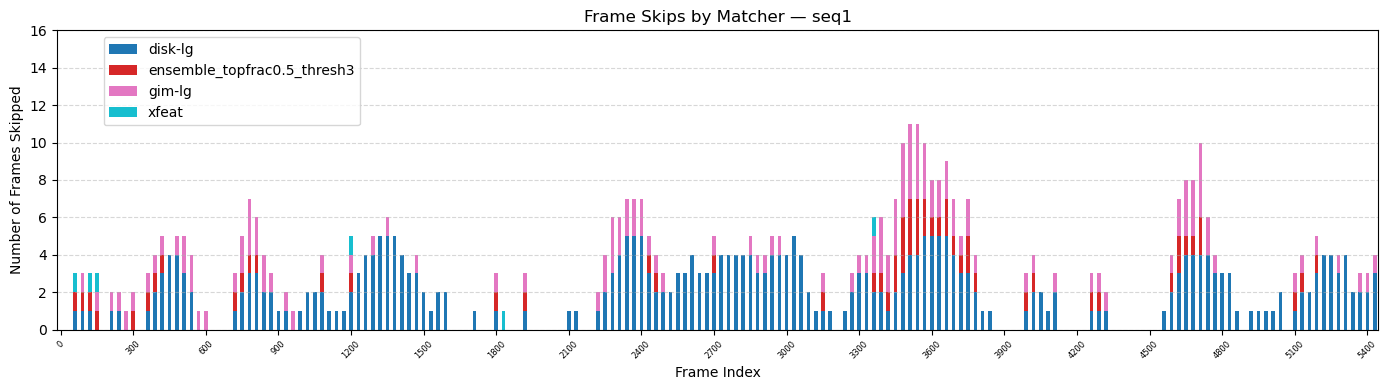

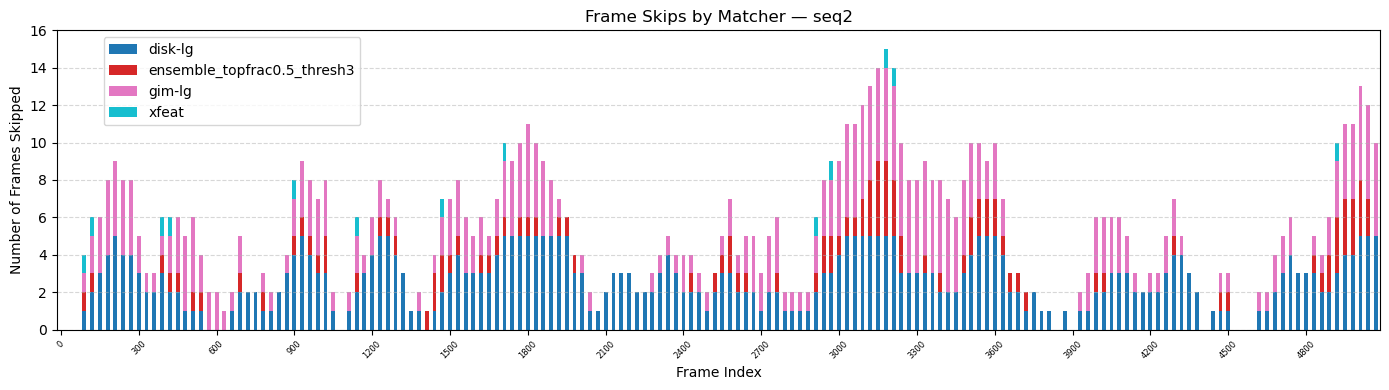

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Output directory for plots
export_dir_stacked = "data_analysis_outputs/screening_plots"
os.makedirs(export_dir, exist_ok=True)

# Matchers and videos
matcher_list = ["xfeat", "gim-lg", "disk-lg", "ensemble_topfrac0.5_thresh3"]
screening_videos = ["seq1", "seq2", "seq3", "seq4", "cecum_t2_b"]

# --- Collect skips into a tidy DataFrame ---
skip_rows = []

for video in screening_videos:
    for matcher in matcher_list:
        # Choose correct base directory
        base_dir = (
            "results/Ensemble_ablation"
            if "ensemble" in matcher
            else "results"
        )

        skip_log_filename = (
            f"skip_log_ensemble.csv"
            if "ensemble" in matcher
            else f"skip_log_{matcher}.csv"
        )

        skip_log_path = os.path.join(base_dir, video, matcher, skip_log_filename)

        if not os.path.isfile(skip_log_path):
            print(f"[SKIP] No skip log for matcher: {matcher} in {video}")
            print(f"[DEBUG] Expected path: {skip_log_path}")
            continue

        df = pd.read_csv(skip_log_path)
        non_empty_skips = df["skipped_frames"].dropna().loc[lambda x: x != "[]"]
        print(f"[DEBUG] {video} | {matcher} — Loaded {len(df)} rows, {len(non_empty_skips)} with skips")

        for _, row in df.iterrows():
            if pd.isna(row["skipped_frames"]) or row["skipped_frames"] == "[]":
                continue

            skipped = [int(s) for s in row["skipped_frames"].strip("[]").split(",") if s.strip()]
            for frame in skipped:
                skip_rows.append({"video": video, "matcher": matcher, "frame": frame})

# --- Build and plot stacked skip bar plots ---
skip_df = pd.DataFrame(skip_rows)

for video in screening_videos:
    video_df = skip_df[skip_df["video"] == video]

    if video_df.empty:
        print(f"[INFO] No skips recorded for video: {video}")
        continue

    # Pivot to wide format: rows=frames, columns=matchers, values=1 if skipped
    pivot_df = video_df.groupby(["frame", "matcher"]).size().unstack(fill_value=0).sort_index()

   # Plot
    # ax = pivot_df.plot(kind="bar", stacked=True, figsize=(14, 4), colormap="tab10")
    # plt.title(f"Frame Skips by Matcher — {video}")
    # plt.xlabel("Frame Index (x30 = original frame number)")
    # plt.ylabel("Number of Matchers That Skipped Frame")

    # # Set custom x-ticks: show every 10th bar and label it with the original frame index * 30
    # frame_indices = pivot_df.index.tolist()
    # tick_locs = list(range(0, len(frame_indices), 10))
    # tick_labels = [frame_indices[i] * 30 for i in tick_locs]

    # plt.xticks(tick_locs, tick_labels, fontsize=6, rotation=45)

    # plt.legend(title="Matcher", bbox_to_anchor=(1.01, 1), loc="upper left")
    # plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    # plt.tight_layout()

        # Pivot to wide format
    pivot_df = video_df.groupby(["frame", "matcher"]).size().unstack(fill_value=0).sort_index()

    # Ensure index starts at 0 and fills any missing frames with zeros
    max_frame = pivot_df.index.max()
    full_index = pd.RangeIndex(start=0, stop=max_frame + 1, step=1)
    pivot_df = pivot_df.reindex(full_index, fill_value=0)

    # Plot
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(14, 4), colormap="tab10")
    plt.title(f"Frame Skips by Matcher — {video}")
    plt.xlabel("Frame Index")
    plt.ylabel("Number of Frames Skipped")
    plt.ylim(0, 16)

    frame_indices = pivot_df.index.tolist()
    tick_locs = list(range(0, len(frame_indices), 10))
    tick_labels = [frame_indices[i] * 30 for i in tick_locs]
    plt.xticks(tick_locs, tick_labels, fontsize=6, rotation=45)

    plt.legend(bbox_to_anchor=(0.03, 1), loc="upper left")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(export_dir, f"stacked_skips_{video}.png"), dpi=300)
    



[DEBUG] seq1 | xfeat — Loaded 175 rows, 5 with skips
[DEBUG] seq1 | gim-lg — Loaded 140 rows, 46 with skips
[DEBUG] seq1 | disk-lg — Loaded 136 rows, 84 with skips
[SKIP] No skip log for matcher: ensemble_topfrac0.5_thresh3 in seq1
[DEBUG] Expected path: results/seq1/ensemble_topfrac0.5_thresh3/skip_log_ensemble.csv
[DEBUG] seq2 | xfeat — Loaded 156 rows, 10 with skips
[DEBUG] seq2 | gim-lg — Loaded 132 rows, 79 with skips
[DEBUG] seq2 | disk-lg — Loaded 134 rows, 102 with skips
[SKIP] No skip log for matcher: ensemble_topfrac0.5_thresh3 in seq2
[DEBUG] Expected path: results/seq2/ensemble_topfrac0.5_thresh3/skip_log_ensemble.csv
[DEBUG] seq3 | xfeat — Loaded 141 rows, 10 with skips
[DEBUG] seq3 | gim-lg — Loaded 110 rows, 50 with skips
[DEBUG] seq3 | disk-lg — Loaded 109 rows, 69 with skips
[SKIP] No skip log for matcher: ensemble_topfrac0.5_thresh3 in seq3
[DEBUG] Expected path: results/seq3/ensemble_topfrac0.5_thresh3/skip_log_ensemble.csv
[DEBUG] seq4 | xfeat — Loaded 136 rows, 17 

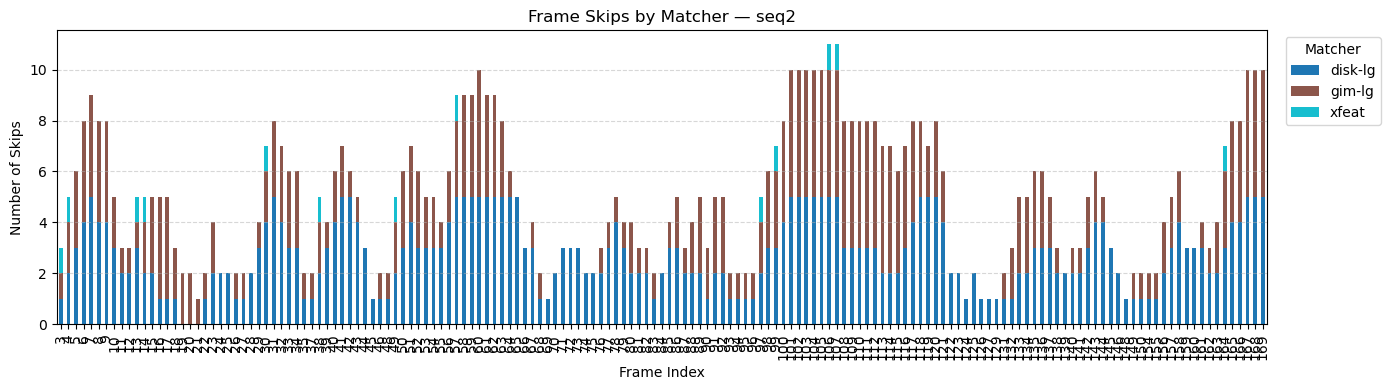

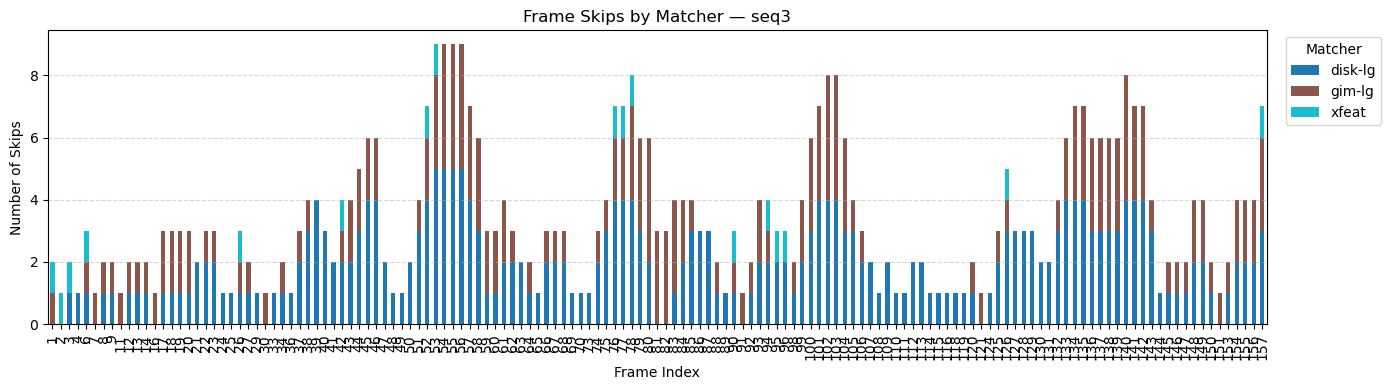

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

base_dir = "results"  # or your actual base
export_dir = "screening_plots"
os.makedirs(export_dir, exist_ok=True)

matcher_list = ["xfeat", "gim-lg", "disk-lg", "ensemble_topfrac0.5_thresh3"]
screening_videos = ["seq1", "seq2", "seq3", "seq4"]

# --- Collect skips into a tidy DataFrame ---
skip_rows = []

for video in screening_videos:
    for matcher in matcher_list:
        skip_log_path = os.path.join(
            base_dir,
            video,
            matcher,
            f"skip_log_{matcher}.csv" if "ensemble" not in matcher else "skip_log_ensemble.csv"
        )
        if not os.path.isfile(skip_log_path):
            print(f"[SKIP] No skip log for matcher: {matcher} in {video}")
            print(f"[DEBUG] Expected path: {skip_log_path}")
            continue

        df = pd.read_csv(skip_log_path)
        non_empty_skips = df["skipped_frames"].dropna().loc[lambda x: x != "[]"]
        print(f"[DEBUG] {video} | {matcher} — Loaded {len(df)} rows, {len(non_empty_skips)} with skips")


        for _, row in df.iterrows():
            if pd.isna(row["skipped_frames"]) or row["skipped_frames"] == "[]":
                continue

            skipped = [int(s) for s in row["skipped_frames"].strip("[]").split(",") if s.strip()]
            for frame in skipped:
                skip_rows.append({"video": video, "matcher": matcher, "frame": frame})

# --- Build and plot stacked skip bar plots ---
skip_df = pd.DataFrame(skip_rows)

for video in screening_videos:
    video_df = skip_df[skip_df["video"] == video]

    if video_df.empty:
        continue

    # Pivot to wide format: rows=frames, columns=matchers, values=1 if skipped
    pivot_df = video_df.groupby(["frame", "matcher"]).size().unstack(fill_value=0).sort_index()

    # Plot
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(14, 4), colormap="tab10")
    plt.title(f"Frame Skips by Matcher — {video}")
    plt.xlabel("Frame Index")
    plt.ylabel("Number of Skips")
    plt.legend(title="Matcher", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # Save and show
    plt.savefig(os.path.join(export_dir, f"stacked_skips_{video}.png"), dpi=300)
    plt.show()
    plt.close()


### RPE Breakdown by Ensemble

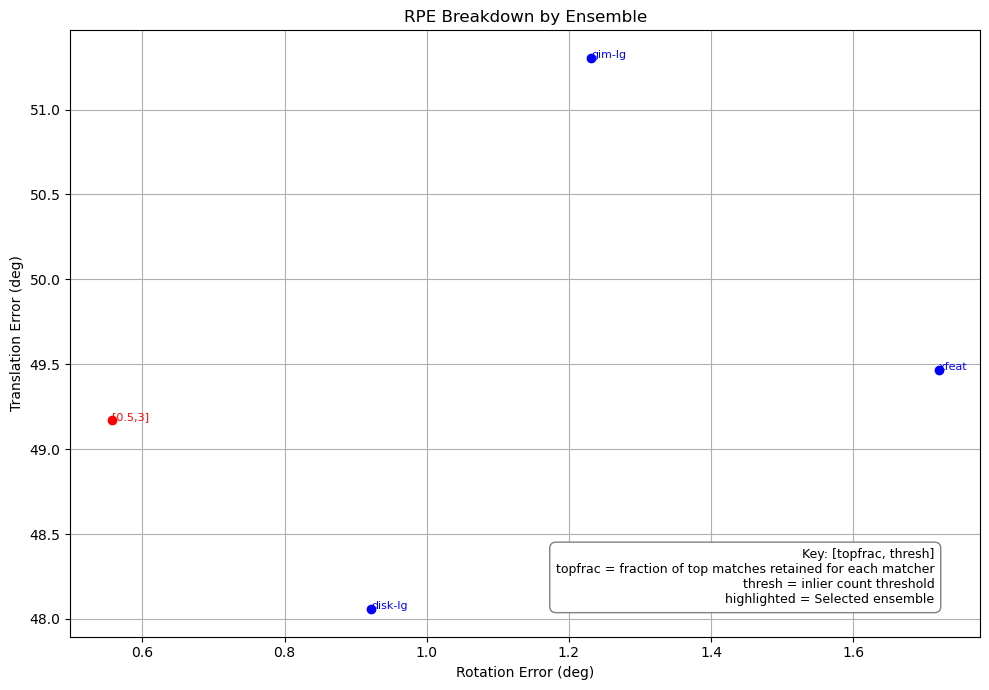

In [14]:
### Average RPE trans vs Rot by matcher ensemble - scatter plot
import matplotlib.pyplot as plt
import re

# Define the matcher labels you want to highlight
highlight_set = {
    ("0.5", "3"),

}

plt.figure(figsize=(10, 7))

for _, row in summary_df.iterrows():
    matcher = row["matcher"]
    x = row["rotation_error_deg_mean"]
    y = row["translation_error_deg_mean"]
    
    # Extract topfrac and thresh
    match = re.search(r"topfrac(\d\.\d)_thresh(\d+)", matcher)
    if match:
        topfrac, thresh = match.groups()
        label = f"[{topfrac},{thresh}]"
        is_highlight = (topfrac, thresh) in highlight_set
    else:
        label = matcher
        is_highlight = False

    # Choose color based on highlight
    color = "red" if is_highlight else "blue"
    
    plt.scatter(x, y, color=color)
    plt.annotate(label, (x, y), fontsize=8, color=color)

# Axis labels and title
plt.xlabel("Rotation Error (deg)")
plt.ylabel("Translation Error (deg)")
plt.title("RPE Breakdown by Ensemble")
plt.grid(True)
plt.tight_layout()

# Key box inside the plot
plt.text(
    0.95, 0.05,
    "Key: [topfrac, thresh]\n"
    "topfrac = fraction of top matches retained for each matcher\n"
    "thresh = inlier count threshold\n"
    "highlighted = Selected ensemble",
    transform=plt.gca().transAxes,
    fontsize=9,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
)

plt.savefig(os.path.join(export_dir, 'RPE_trans_rot_by_ensemble.png'), dpi=300)
# plt.close()


### RPE combined versus ATE - averaged across all videos

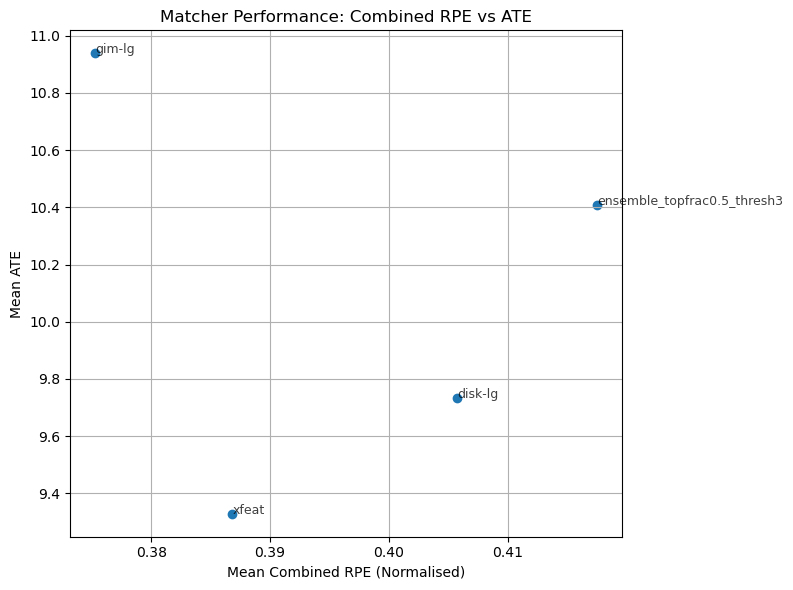

Pearson correlation: -0.178
Spearman correlation: -0.200


In [15]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Ensure necessary columns exist
if "combined_rpe_normalised_mean" in summary_df.columns and "ATE_mean" in summary_df.columns:
    x = summary_df["combined_rpe_normalised_mean"]
    y = summary_df["ATE_mean"]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y)
    for i, label in enumerate(summary_df["matcher"]):
        plt.annotate(label, (x[i], y[i]), fontsize=9, alpha=0.75)

    plt.xlabel("Mean Combined RPE (Normalised)")
    plt.ylabel("Mean ATE")
    plt.title("Matcher Performance: Combined RPE vs ATE")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig("matcher_rpe_vs_ate.png", dpi=300)
    plt.show()

    # Correlation
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)

    print(f"Pearson correlation: {pearson_corr:.3f}")
    print(f"Spearman correlation: {spearman_corr:.3f}")
else:
    print("Required columns not found in summary_df.")


[cecum_t1_a] Pearson: -0.11, Spearman: -0.40
[cecum_t1_b] Pearson: 0.50, Spearman: 0.20
[cecum_t2_a] Pearson: -0.77, Spearman: -0.80


[cecum_t2_b] Pearson: 0.64, Spearman: 0.40
[cecum_t2_c] Pearson: -0.93, Spearman: -1.00
[cecum_t3_a] Pearson: -0.74, Spearman: -0.60
[cecum_t4_a] Pearson: 0.02, Spearman: 0.00
[cecum_t4_b] Pearson: -0.08, Spearman: -0.20
[desc_t4_a] Insufficient data
[sigmoid_t1_a] Pearson: 0.21, Spearman: -0.20
[sigmoid_t2_a] Pearson: -0.59, Spearman: -0.40
[sigmoid_t3_a] Pearson: 0.44, Spearman: 0.20
[sigmoid_t3_b] Pearson: -0.44, Spearman: 0.00
[trans_t1_a] Insufficient data
[trans_t1_b] Pearson: -0.70, Spearman: -0.80
[trans_t2_a] Pearson: 1.00, Spearman: 1.00
[trans_t2_b] Insufficient data
[trans_t2_c] Pearson: 0.19, Spearman: 0.00
[trans_t3_a] Pearson: 0.98, Spearman: 1.00
[trans_t3_b] Pearson: 0.92, Spearman: 1.00
[trans_t4_a] Pearson: -0.31, Spearman: -0.20


/tmp/ipykernel_2649688/449256489.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 5))


[trans_t4_b] Pearson: -0.75, Spearman: -0.40


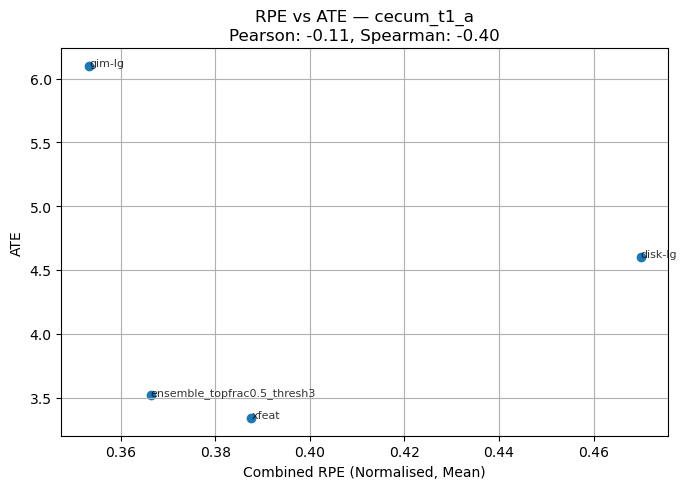

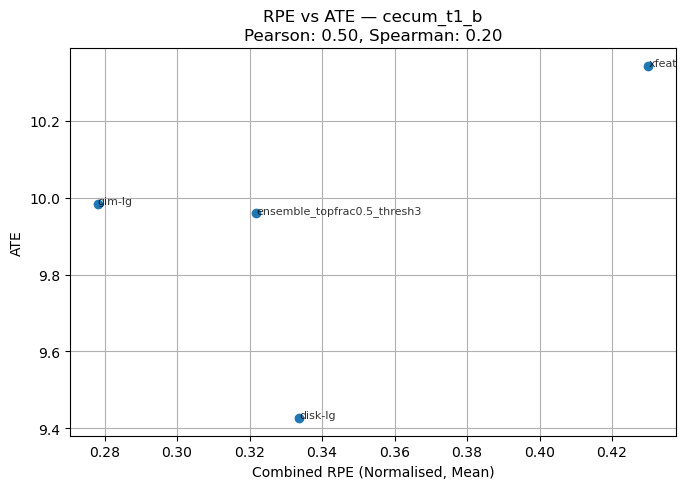

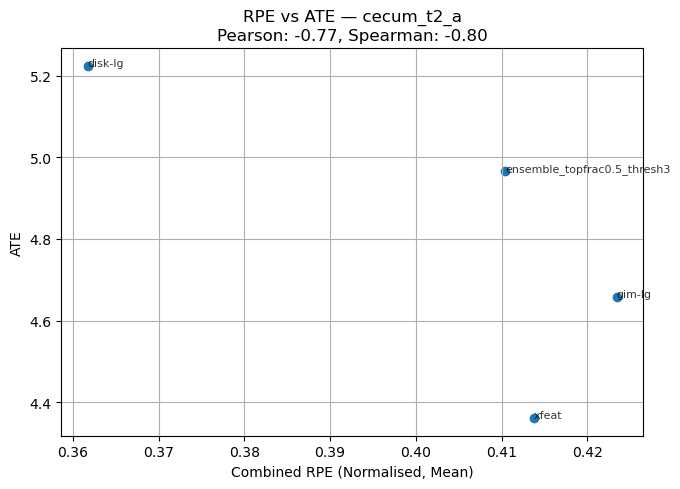

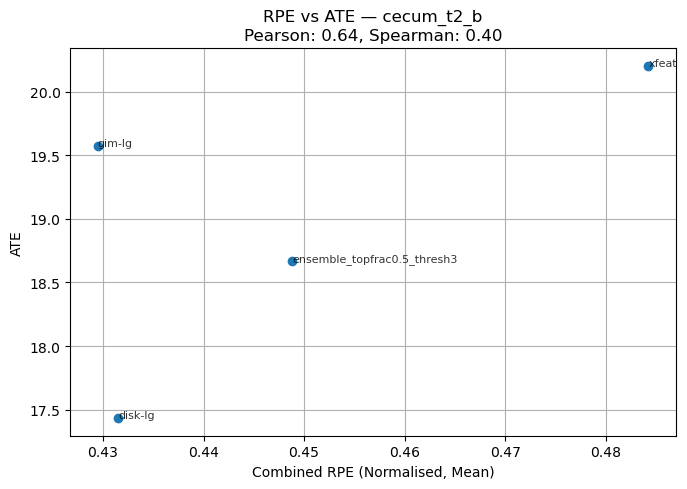

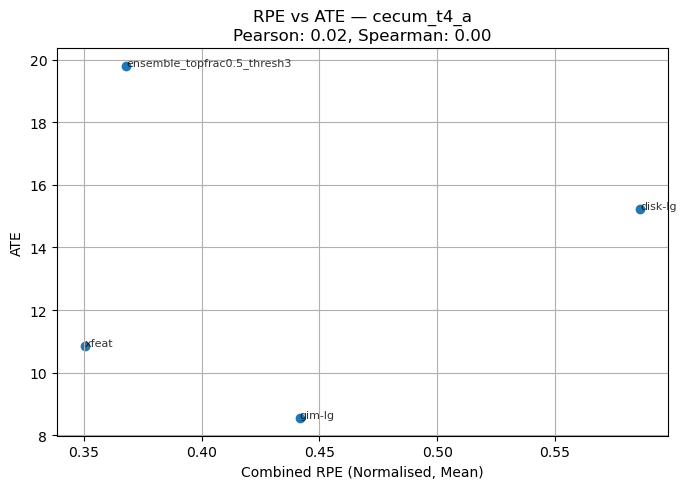

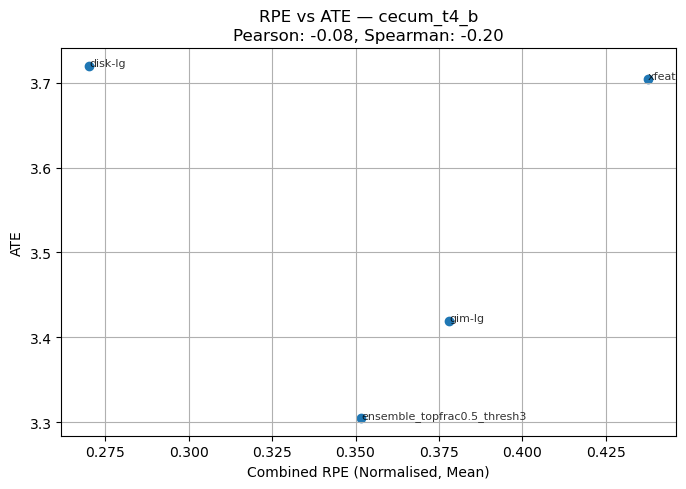

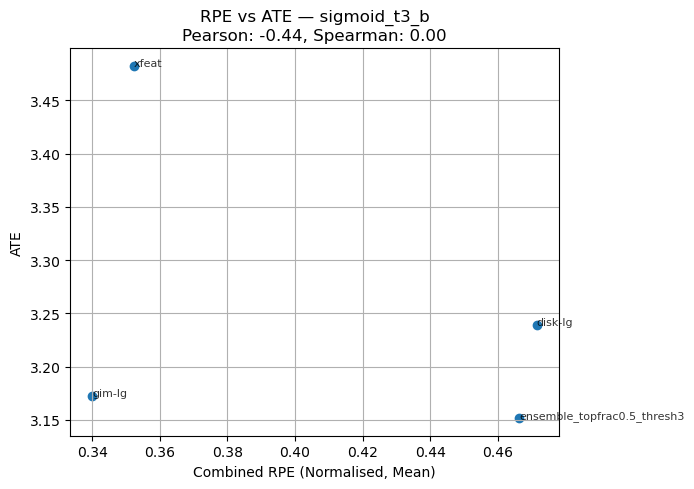

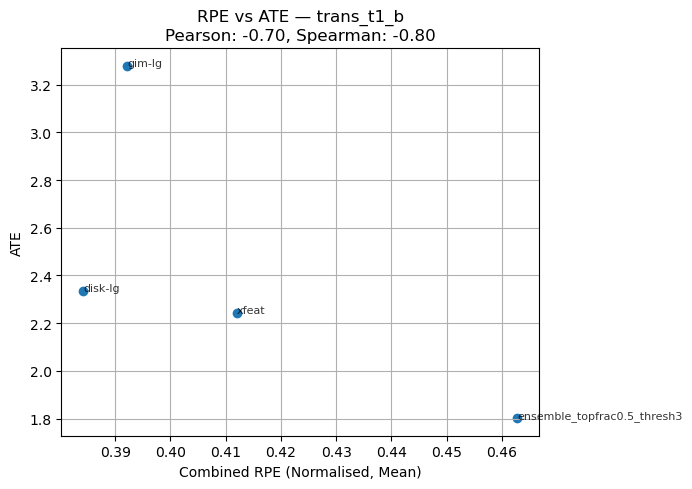

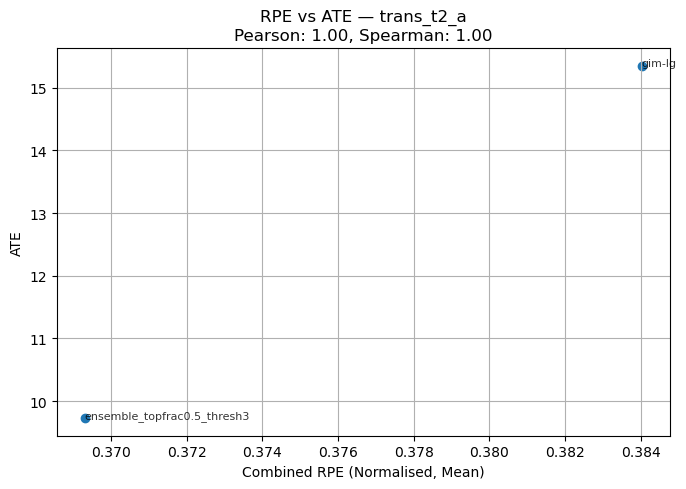

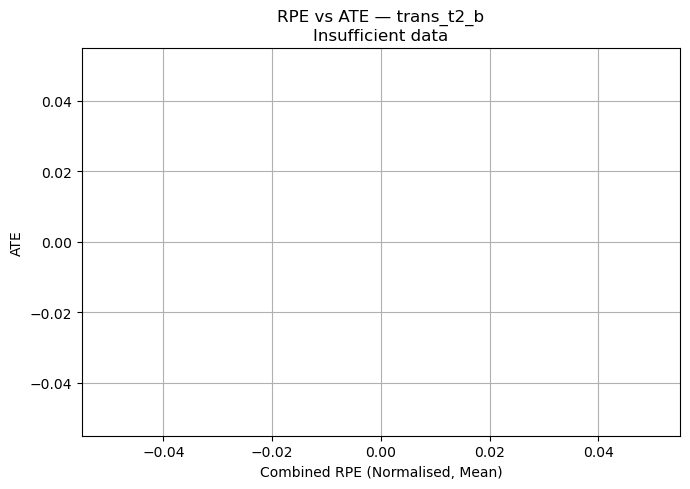

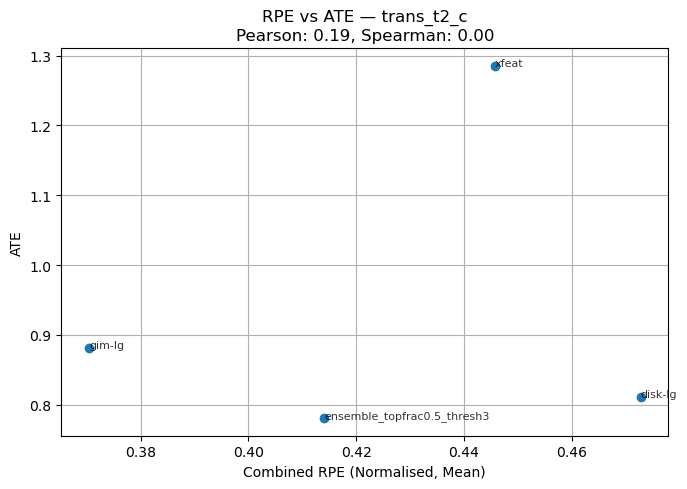

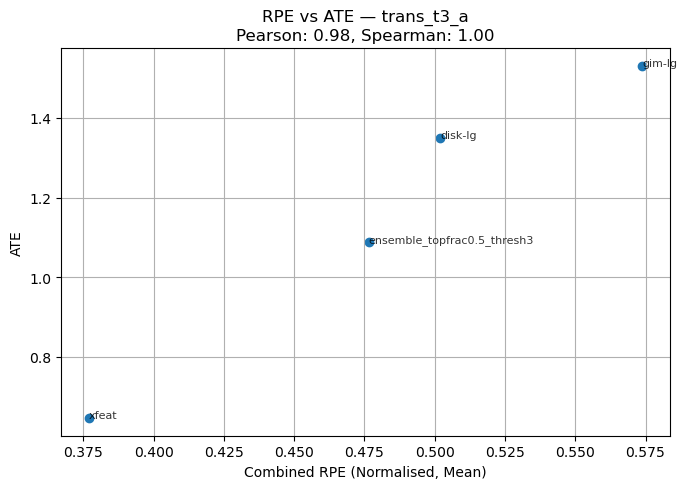

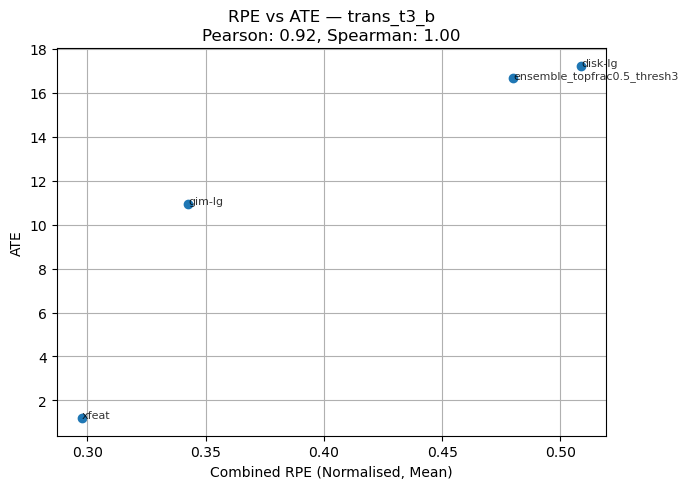

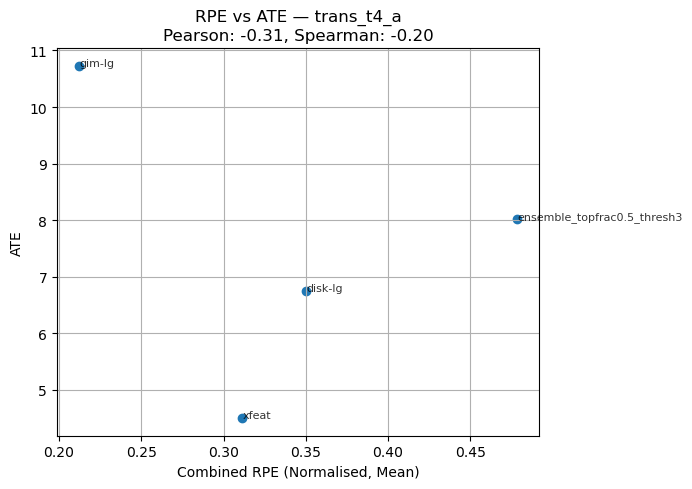

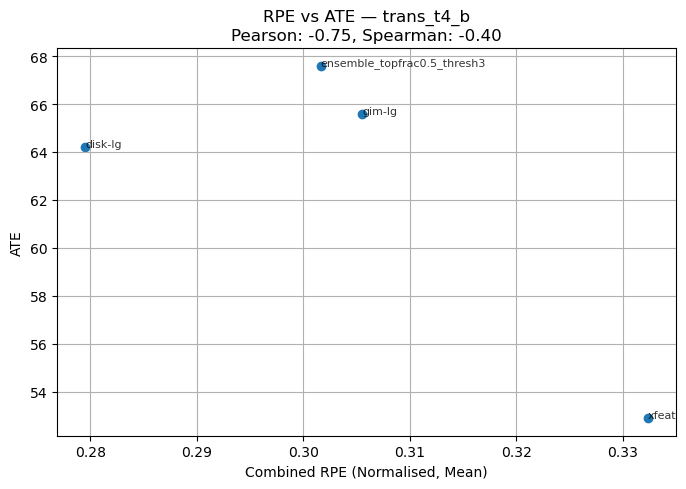

In [16]:
from scipy.stats import pearsonr, spearmanr

# --- Ensure 'video_stats_df' is available and valid ---
assert "video" in video_stats_df.columns and "matcher" in video_stats_df.columns

# --- Plot one figure per video ---
videos = video_stats_df["video"].unique()

for video in videos:
    subset = video_stats_df[video_stats_df["video"] == video]

    # Drop rows with NaNs in either column
    subset = subset.dropna(subset=["combined_rpe_normalised_mean", "ATE"])

    x = subset["combined_rpe_normalised_mean"]
    y = subset["ATE"]

    if len(subset) >= 2:
        pearson_corr, _ = pearsonr(x, y)
        spearman_corr, _ = spearmanr(x, y)
        corr_info = f"Pearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}"
        print(f"[{video}] {corr_info}")
    else:
        corr_info = "Insufficient data"
        print(f"[{video}] {corr_info}")

    plt.figure(figsize=(7, 5))
    plt.scatter(x, y)

    for i, row in subset.iterrows():
        plt.annotate(row["matcher"], 
                     (row["combined_rpe_normalised_mean"], row["ATE"]),
                     fontsize=8, alpha=0.8)

    plt.title(f"RPE vs ATE — {video}\n{corr_info}")
    plt.xlabel("Combined RPE (Normalised, Mean)")
    plt.ylabel("ATE")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"per_video_rpe_vs_ate_{video}.png", dpi=300)
    # plt.close()


### Something to show skips 

### Some basic plot of reproj error

### Basic plot for failure rate 

Available columns: ['matcher', 'rotation_error_deg_mean', 'rotation_error_deg_std', 'translation_error_deg_mean', 'translation_error_deg_std', 'mean_reprojection_error_px_mean', 'mean_reprojection_error_px_std', 'combined_rpe_normalised_mean', 'combined_rpe_normalised_std', 'ATE_mean', 'ATE_std', 'failure_rate', 'avg_skip_used']


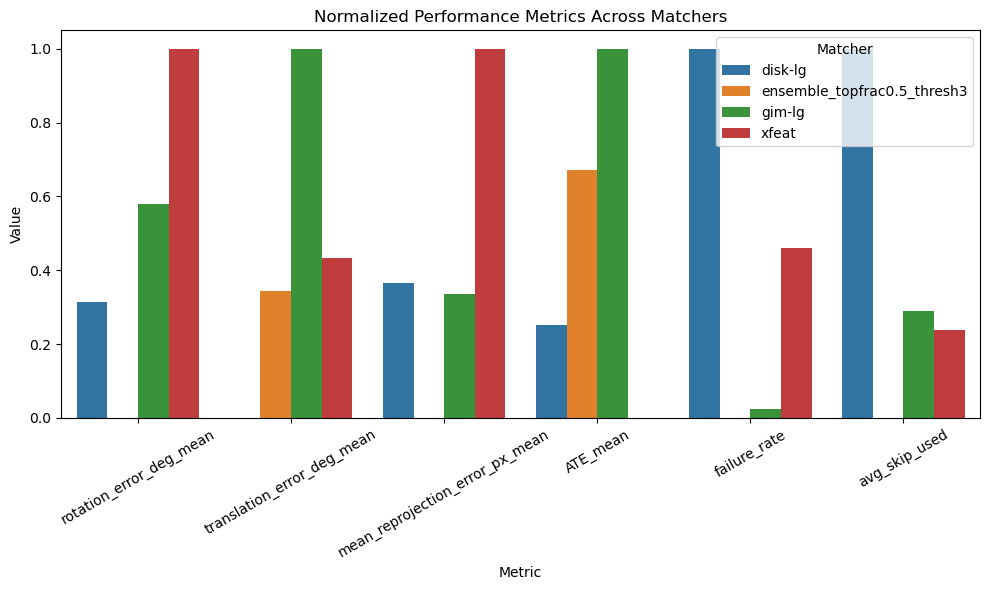

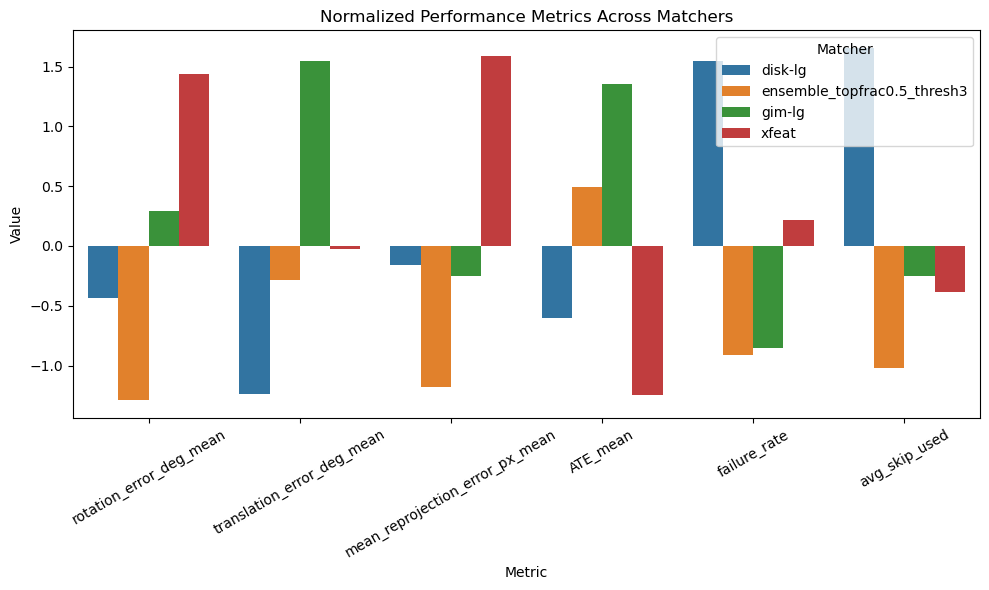

In [17]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# Melt and plot (same as before)

# Define metric columns
metrics = [
    "rotation_error_deg_mean",
    "translation_error_deg_mean",
    "mean_reprojection_error_px_mean",
    "ATE_mean",
    "failure_rate",
    "avg_skip_used"
]

# Check columns present
print("Available columns:", summary_df.columns.tolist())

# Ensure no typos and use the right DataFrame
normalized_df = summary_df.copy()
scaler = MinMaxScaler()
normalized_df[metrics] = scaler.fit_transform(summary_df[metrics])
show_scrollable_df(normalized_df)

scaler = StandardScaler()
standardized_df = summary_df.copy()
standardized_df[metrics] = scaler.fit_transform(summary_df[metrics])
show_scrollable_df(standardized_df)

# Melt for grouped bar plot
plot_df = normalized_df.melt(
    id_vars="matcher",
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="Metric", y="Value", hue="matcher")
plt.xticks(rotation=30)
plt.title("Normalized Performance Metrics Across Matchers")
plt.tight_layout()
plt.legend(title="Matcher")
plt.show()

# Melt for grouped bar plot
plot_df = standardized_df.melt(
    id_vars="matcher",
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="Metric", y="Value", hue="matcher")
plt.xticks(rotation=30)
plt.title("Normalized Performance Metrics Across Matchers")
plt.tight_layout()
plt.legend(title="Matcher")
plt.show()



/tmp/ipykernel_2649688/3666938226.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/3666938226.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/3666938226.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/3666938226.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/3666938226.py:49: UserWar

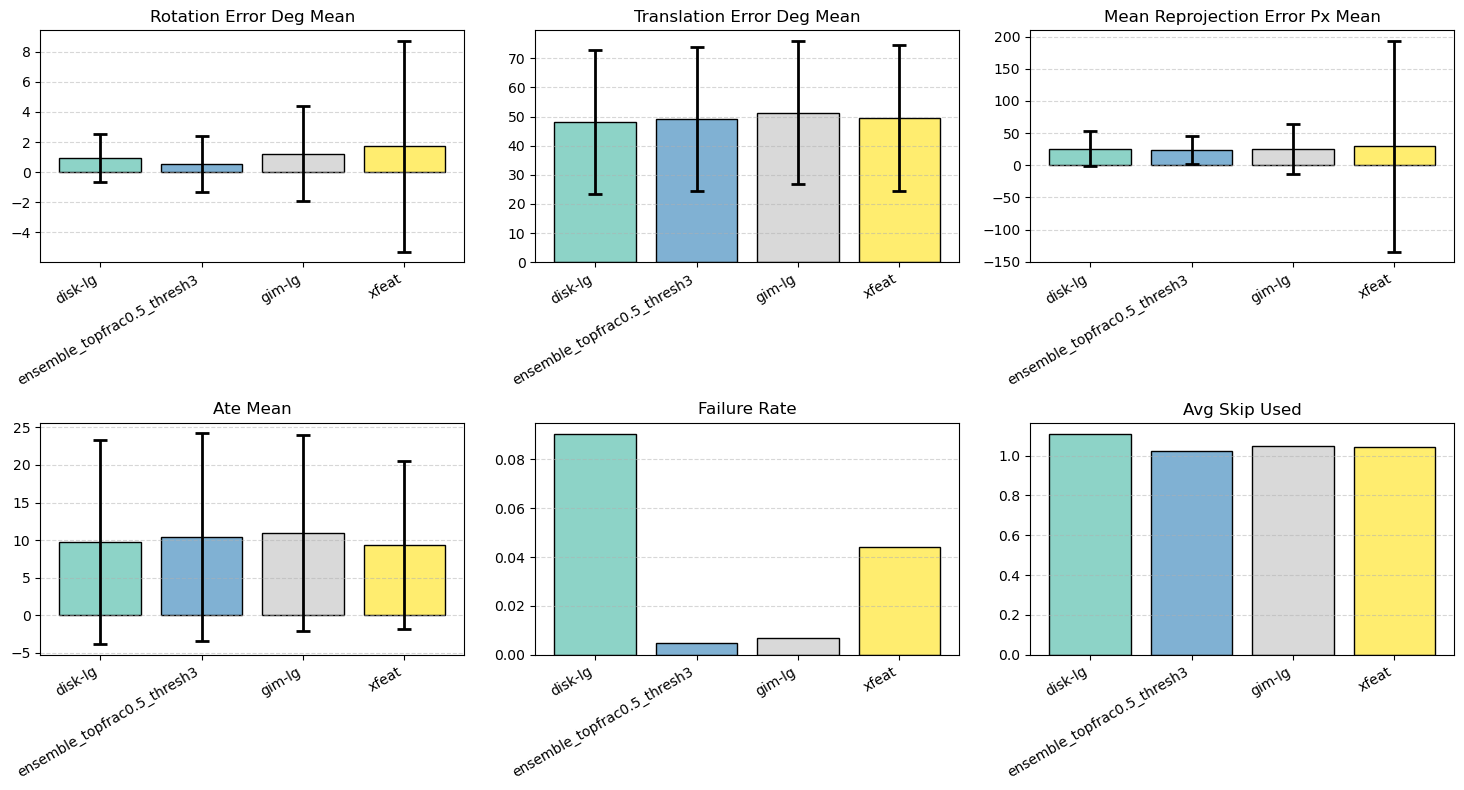

In [18]:
metric_cols = [
    "rotation_error_deg_mean",
    "translation_error_deg_mean", 
    "mean_reprojection_error_px_mean",
    "ATE_mean",
    "failure_rate",
    "avg_skip_used"
]

# Corresponding standard deviation columns (you'll need to create these in summary_df)
std_cols = [
    "rotation_error_deg_std",
    "translation_error_deg_std",
    "mean_reprojection_error_px_std", 
    "ATE_std",
    "failure_rate_std",  # Note: std for failure_rate might not be meaningful
    "avg_skip_used_std"
]

# Create color map for matchers
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Create consistent colors for each matcher
unique_matchers = summary_df["matcher"].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_matchers)))
color_map = dict(zip(unique_matchers, colors))

for ax, col, std_col in zip(axes, metric_cols, std_cols):
    # Get colors for each matcher
    bar_colors = [color_map[matcher] for matcher in summary_df["matcher"]]
    
    # Check if std column exists in dataframe and has non-null values
    if std_col in summary_df.columns and not summary_df[std_col].isna().all():
        # Plot with error bars
        ax.bar(summary_df["matcher"], summary_df[col], 
               yerr=summary_df[std_col], 
               color=bar_colors, edgecolor='black',
               capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})
    else:
        # Plot without error bars if std column doesn't exist or is all NaN
        ax.bar(summary_df["matcher"], summary_df[col], 
               color=bar_colors, edgecolor='black')
    
    ax.set_title(col.replace("_", " ").title())
    ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'full_error_plots.png'), dpi=300)
plt.show()

/tmp/ipykernel_2649688/2832814334.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/2832814334.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/2832814334.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/2832814334.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
/tmp/ipykernel_2649688/2832814334.py:77: UserWar

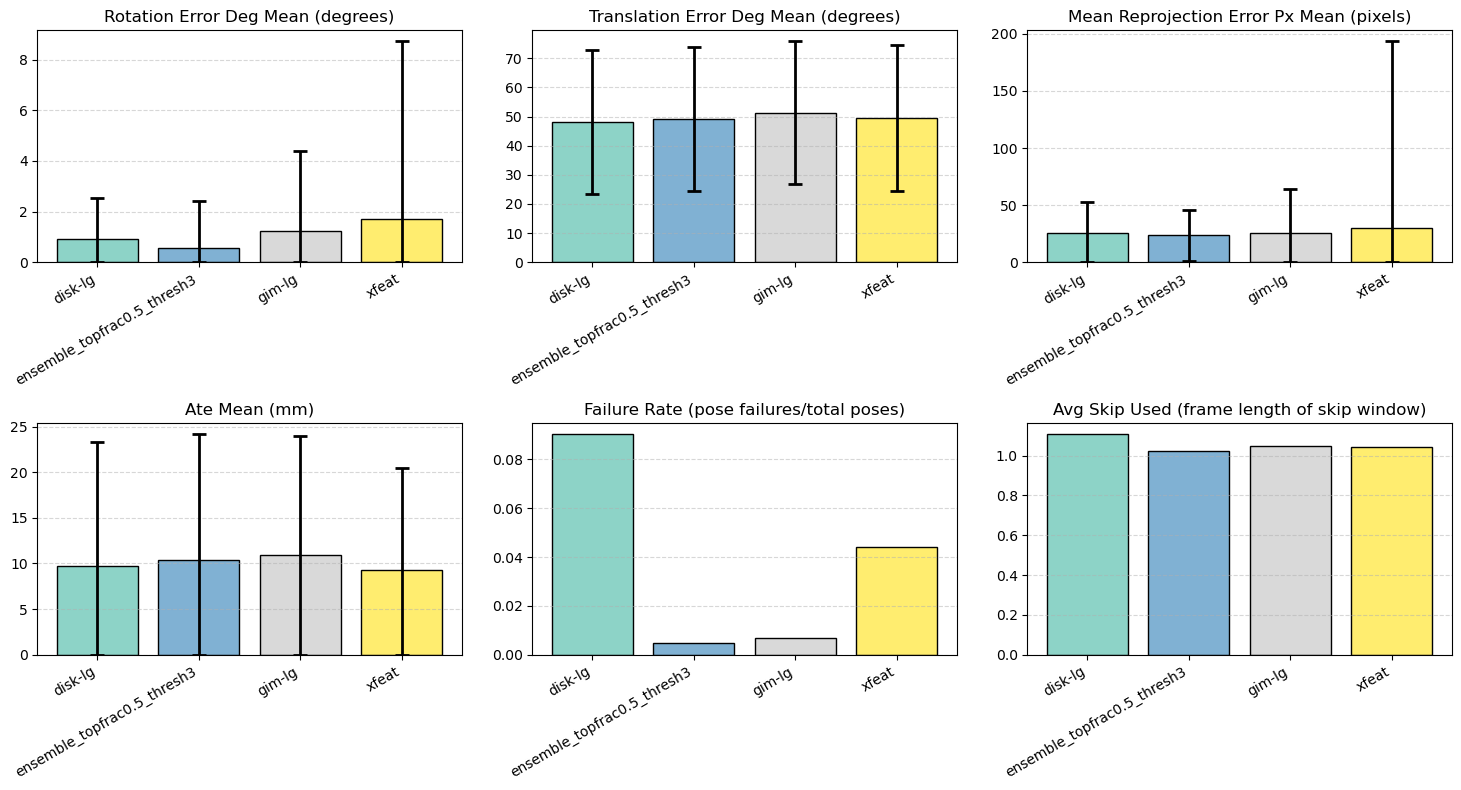

In [19]:
metric_cols = [
    "rotation_error_deg_mean",
    "translation_error_deg_mean", 
    "mean_reprojection_error_px_mean",
    "ATE_mean",
    "failure_rate",
    "avg_skip_used"
]

# Corresponding standard deviation columns (you'll need to create these in summary_df)
std_cols = [
    "rotation_error_deg_std",
    "translation_error_deg_std",
    "mean_reprojection_error_px_std", 
    "ATE_std",
    "failure_rate_std",  # Note: std for failure_rate might not be meaningful
    "avg_skip_used_std"
]

# Define units for each metric
metric_units = {
    "rotation_error_deg_mean": "degrees",
    "translation_error_deg_mean": "degrees", 
    "mean_reprojection_error_px_mean": "pixels",
    "ATE_mean": "mm",
    "failure_rate": "pose failures/total poses",
    "avg_skip_used": "frame length of skip window"
}

# Create color map for matchers
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Create consistent colors for each matcher
unique_matchers = summary_df["matcher"].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_matchers)))
color_map = dict(zip(unique_matchers, colors))

for ax, col, std_col in zip(axes, metric_cols, std_cols):
    # Get colors for each matcher
    bar_colors = [color_map[matcher] for matcher in summary_df["matcher"]]
    
    # Check if std column exists in dataframe and has non-null values
    if std_col in summary_df.columns and not summary_df[std_col].isna().all():
        # For metrics that shouldn't go below zero, clip the lower error bar
        means = summary_df[col]
        stds = summary_df[std_col]
        
        # Create asymmetric error bars (clip lower bound at zero for non-negative metrics)
        if col in ["rotation_error_deg_mean", "translation_error_deg_mean", 
                   "mean_reprojection_error_px_mean", "ATE_mean"]:
            lower_err = np.minimum(stds, means)  # Don't let error bar go below zero
            upper_err = stds
            yerr = [lower_err, upper_err]
        else:
            yerr = stds
            
        # Plot with error bars
        ax.bar(summary_df["matcher"], means, 
               yerr=yerr, 
               color=bar_colors, edgecolor='black',
               capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})
    else:
        # Plot without error bars if std column doesn't exist or is all NaN
        ax.bar(summary_df["matcher"], summary_df[col], 
               color=bar_colors, edgecolor='black')
    
    # Create title with units
    title = col.replace("_", " ").title()
    if col in metric_units:
        title += f" ({metric_units[col]})"
    
    ax.set_title(title)
    ax.set_xticklabels(summary_df["matcher"], rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(export_dir, 'full_error_plots.png'), dpi=300)
plt.show()